## Classification
Notebook to evaluate efficacy of classification between different thalamic cell type groups

In [25]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestCentroid
import pickle
import json

### To do:
1) Benchmark simple Wilcoxon selection, for various sizes of gene panels
2) Benchmark w/ and w/o absolute values

In [26]:
# Load in pre-processed data from glutamatergic class designation, subclass to all rank_gene_groups already performed
gluData = sc.read("../Data/clData.h5ad")

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
# Acquire genes
def getUniqueGenes(geneDict, perClass = 1):
    """ Function to find X number of genes per class for a given gene dictionary, and assemble them
    into a list of unique genes. """
    import numpy as np
    
    keyNames = list(geneDict.keys())
    if perClass > len(geneDict[keyNames[0]]):
        print("Requested genes per class greater than number contained within first dict element - using that instead.")
        perClass = len(geneDict[keyNames[0]])
    
    geneList = []
    for name in keyNames:
        geneList.append(geneDict[name][0:perClass])
        
    geneList = np.unique(geneList)
    return geneList

In [4]:
def evalPanel(geneData,genePanel,cluster, showPlot = True):
    """ Function to evaluate the accuracy of a gene panel and plot confusion matrices if requested"""
    from sklearn.neighbors import NearestCentroid
    from scanpy.metrics import confusion_matrix
    import seaborn as sns
    
    # Project data onto input gene panel, then establish a nearest centroid classifier
    projGenes = geneData[:,genePanel].X
    nn = NearestCentroid()
    nn.fit(projGenes,cluster)
    assignedCluster = nn.predict(projGenes)
    accuracy = nn.score(projGenes,cluster)
    # Plot confusion matrix if requested
    if showPlot:
        plt.figure(figsize=(48, 32), dpi=80)
        confMatrix = confusion_matrix(cluster,assignedCluster)
        ax = sns.heatmap(confMatrix) # cmap = "viridis")
        plt.xticks(np.linspace(0.5,201.5,202), pd.unique(cluster), fontsize = 8)
        plt.yticks(np.linspace(0.5,201.5,202), pd.unique(cluster), fontsize = 8)
        plt.title("Classification Accuracy: %1.1f%%" %round(accuracy*100,2),fontsize=36)
        plt.xlabel("Original Label", fontsize = 24)
        plt.ylabel("Assigned Label", fontsize = 24)
        return accuracy, ax, confMatrix
    else:
        return accuracy

In [5]:
# Create a super list dictionary of top marker genes for each subclass, which can be later indexed for specific gene panels
markerGenes = {}
for indx in gluData.uns["rank_genes_groups"]["pts"].columns:
    genesRanked = pd.DataFrame(
            {key: gluData.uns["rank_genes_groups"][key][indx]
            for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
    pts = gluData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
    pts_rest = gluData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
    pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
    genesRanked = pd.concat([genesRanked, pts, pts_rest, pts_diff], axis=1)
    genesRanked = genesRanked.sort_values(by=["scores"], ascending=False, key=abs)
    genesFiltered = genesRanked.iloc[0:500,:]
    genesFiltered = genesFiltered.sort_values(by=["pts_diff"], ascending=False)
    markerGenes[indx] = genesFiltered["names"][0:32].tolist()

In [6]:
# Assemble a dictionary w/ varying length gene panels
wlPanel = {}
panelIDs = [1, 2, 3, 4, 8, 16, 32]
for i in panelIDs:
    geneList = list(getUniqueGenes(markerGenes,i))
    wlPanel[str(len(geneList))] = geneList

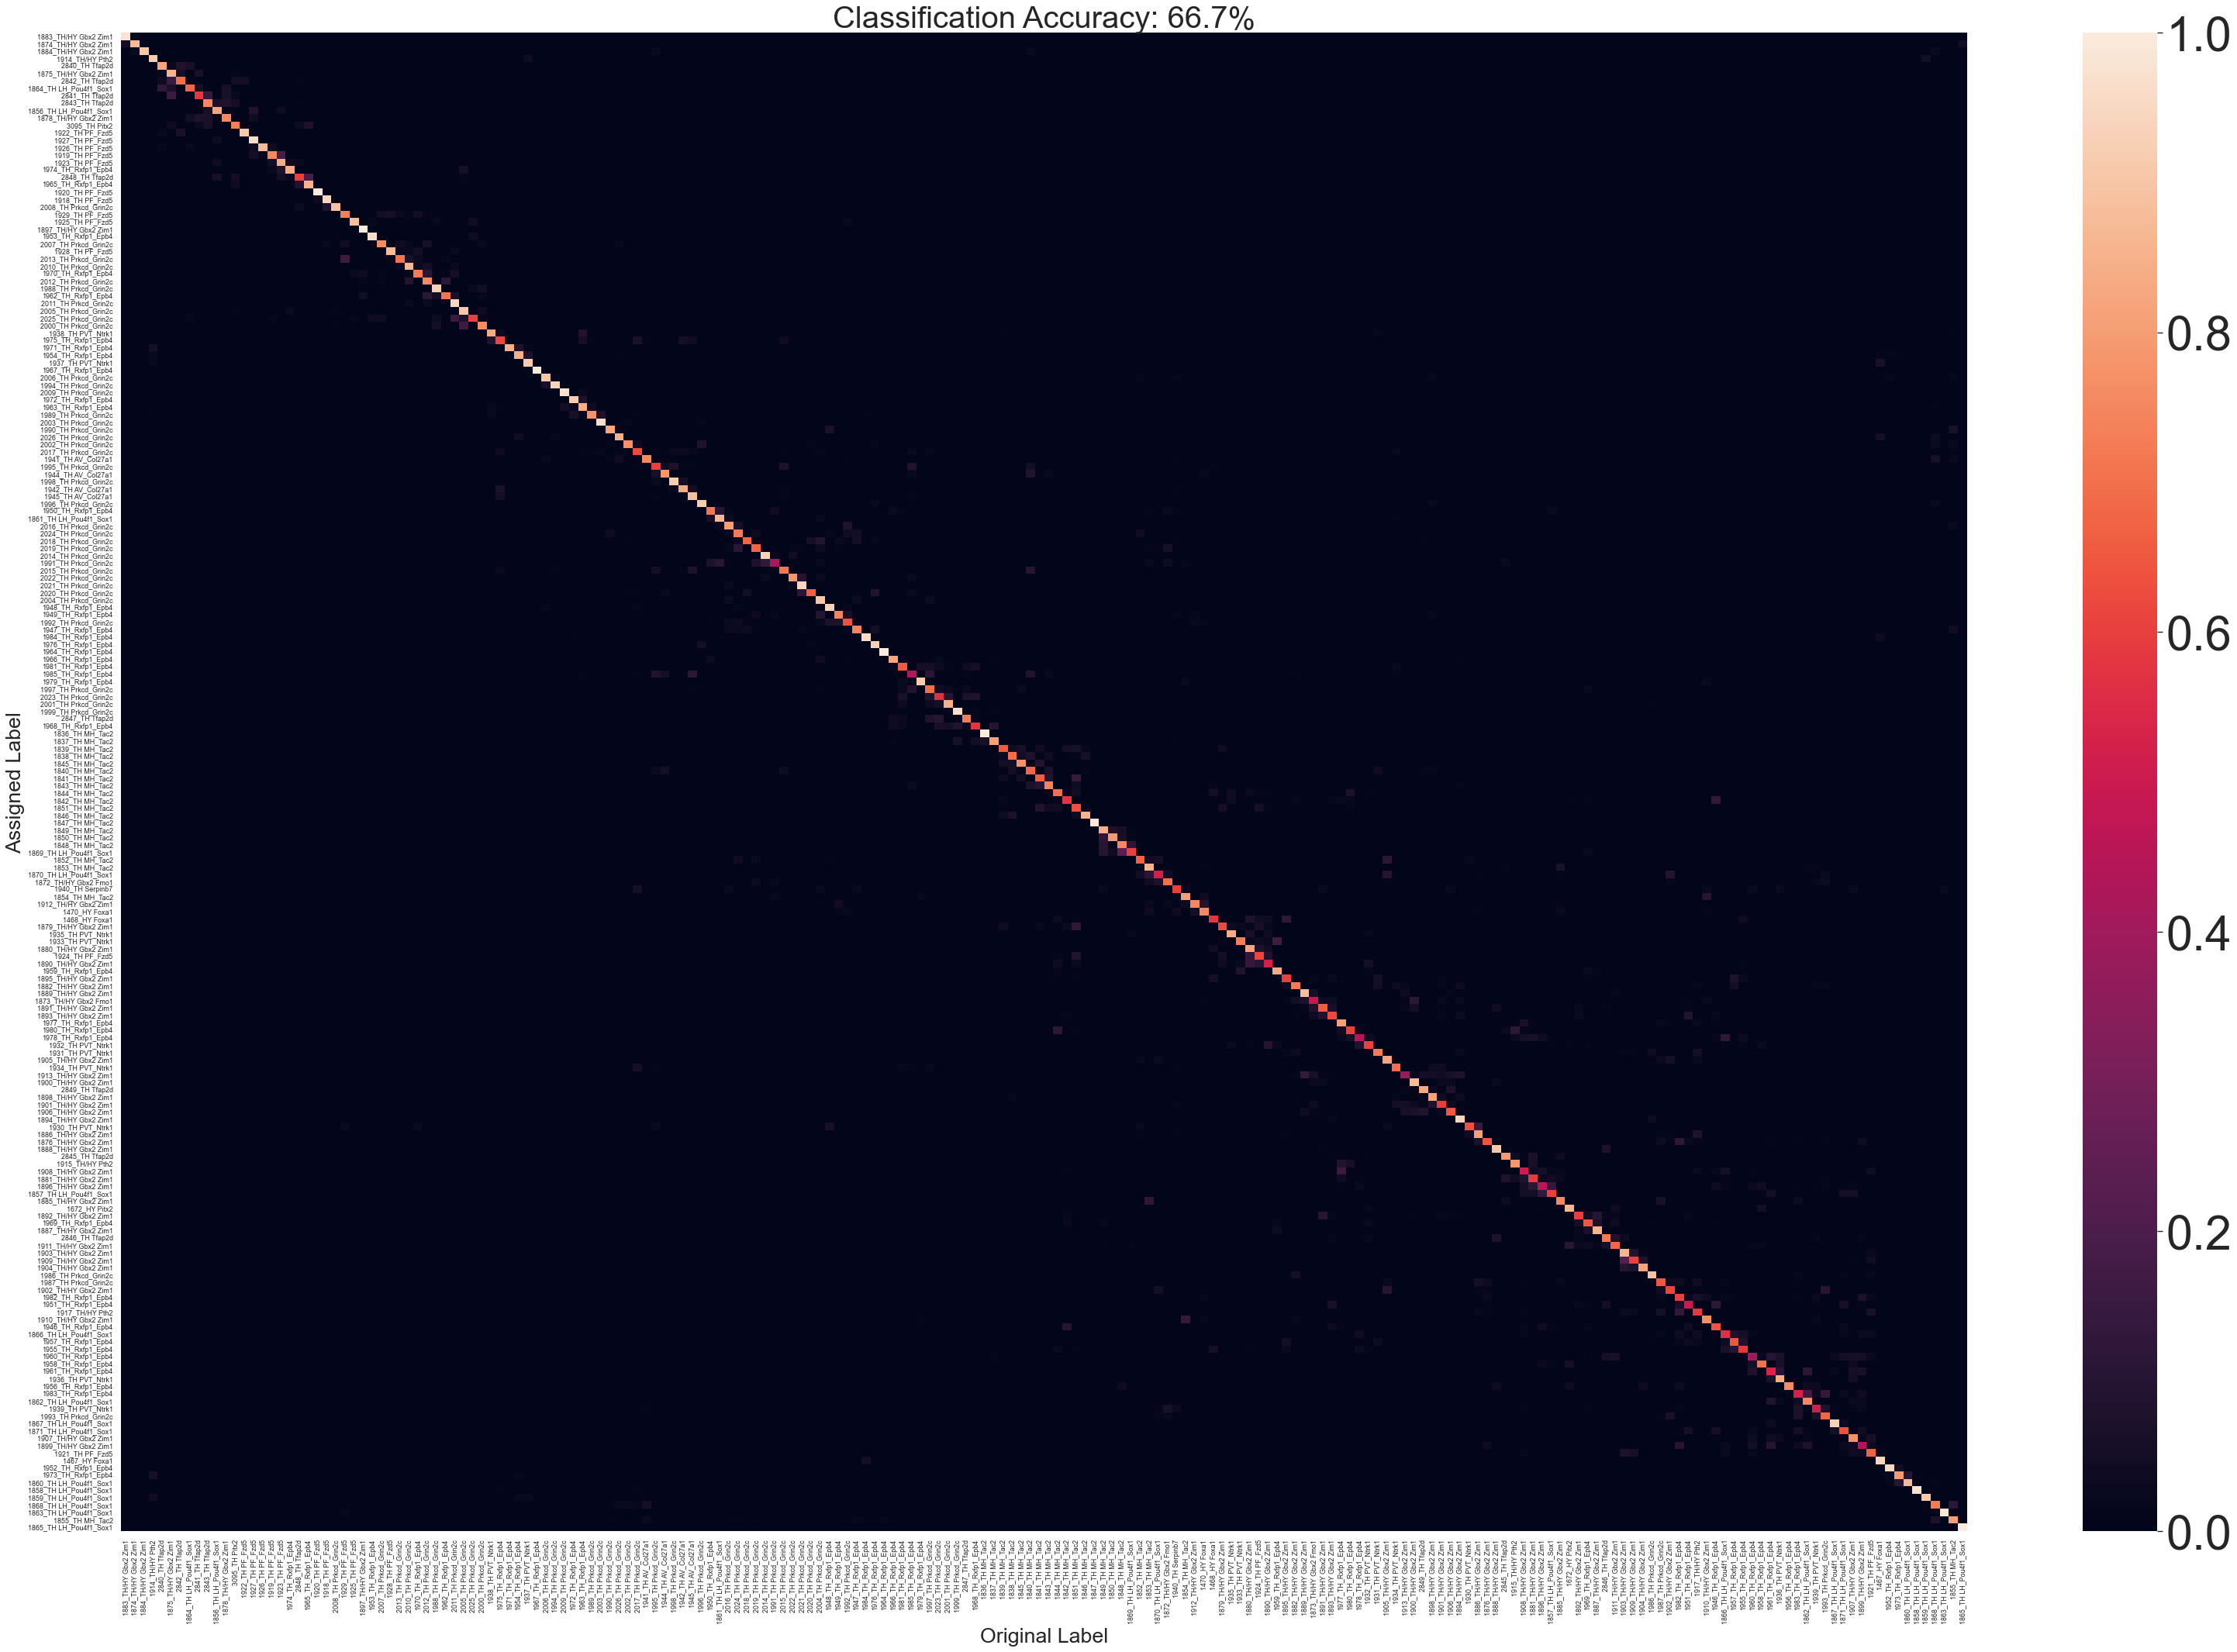

In [50]:
# Check how a particular gene panel does w/ confusion matrix
# plt.figure(figsize=(12, 8), dpi=160)
evalPanel(gluData,wlPanel['117'],gluData.obs["cluster_label"],True);

Text(0.5, 1.0, 'Gene Panel Efficacy: Wilcoxon Method')

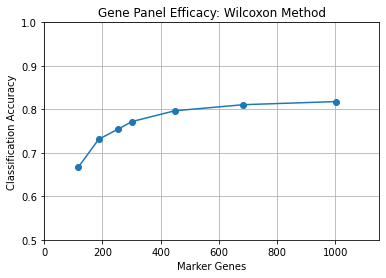

In [7]:
# Systematically evaluate gene panels
wlAccuracy = [evalPanel(gluData,wlPanel[i],gluData.obs["cluster_label"],False) for i in wlPanel.keys()]
# Plot results
fig, ax = plt.subplots()
plt.plot(np.fromiter(wlPanel.keys(),'int'),wlAccuracy,'o-')
ax.set_ylim(0.5, 1)
ax.set_xlim(0, 1150)
plt.grid()
plt.xlabel("Marker Genes")
plt.ylabel("Classification Accuracy")
plt.title("Gene Panel Efficacy: Wilcoxon Method")

## Compare gene selectors
Use gene panels provided by Wilcoxon rank testing, scGeneFit, PROPOSE (in progress)

In [8]:
with open("../Data/Gene Panels/scGeneFit_cluster_genes.json", "r") as f:
    gfPanel = json.load(f)
    
with open("../Data/Gene Panels/PROPOSE_cluster_genes.json", "r") as f:
    prPanel = json.load(f)
    
with open("../Data/Gene Panels/activeSVM_cluster_genes.json", "r") as f:
    svPanel = json.load(f)

In [9]:
# Systematically evaluate gene panels
wlAccuracy = [evalPanel(gluData,wlPanel[i],gluData.obs["cluster_label"],False) for i in wlPanel.keys()]
gfAccuracy = [evalPanel(gluData,gfPanel[i],gluData.obs["cluster_label"],False) for i in gfPanel.keys()]
prAccuracy = [evalPanel(gluData,prPanel[i],gluData.obs["cluster_label"],False) for i in prPanel.keys()]
svAccuracy = [evalPanel(gluData,svPanel[i],gluData.obs["cluster_label"],False) for i in svPanel.keys()]

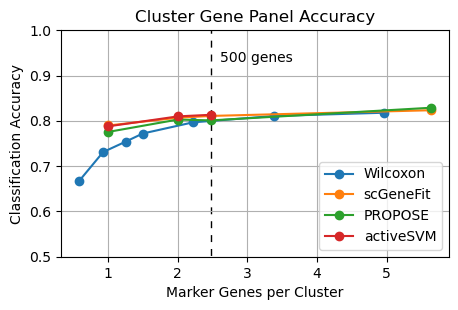

In [128]:
# Plot benchmarking
plt.figure(figsize=(5, 3), dpi=100)
nClusters = len(gluData.obs["cluster_label"].unique())
plt.plot(np.fromiter(wlPanel.keys(), dtype='int')/nClusters,wlAccuracy,'o-',label="Wilcoxon")
plt.plot(np.fromiter(gfPanel.keys(), dtype='int')/nClusters,gfAccuracy,'o-', label="scGeneFit")
plt.plot(np.fromiter(prPanel.keys(), dtype='int')/nClusters,prAccuracy,'o-', label="PROPOSE")
plt.plot(np.fromiter(svPanel.keys(), dtype='int')/nClusters,svAccuracy,'o-', label="activeSVM")

# Clean up plot
plt.ylim(0.5,1)
plt.grid()
plt.xlabel("Marker Genes per Cluster")
plt.ylabel("Classification Accuracy")
plt.title("Cluster Gene Panel Accuracy")
plt.plot([(500 / nClusters), (500 / nClusters)], [0, 1], 'k-', lw=1,dashes=[5, 5],zorder=0) # add reference line
plt.text(2.6,.93, '500 genes')
plt.legend()

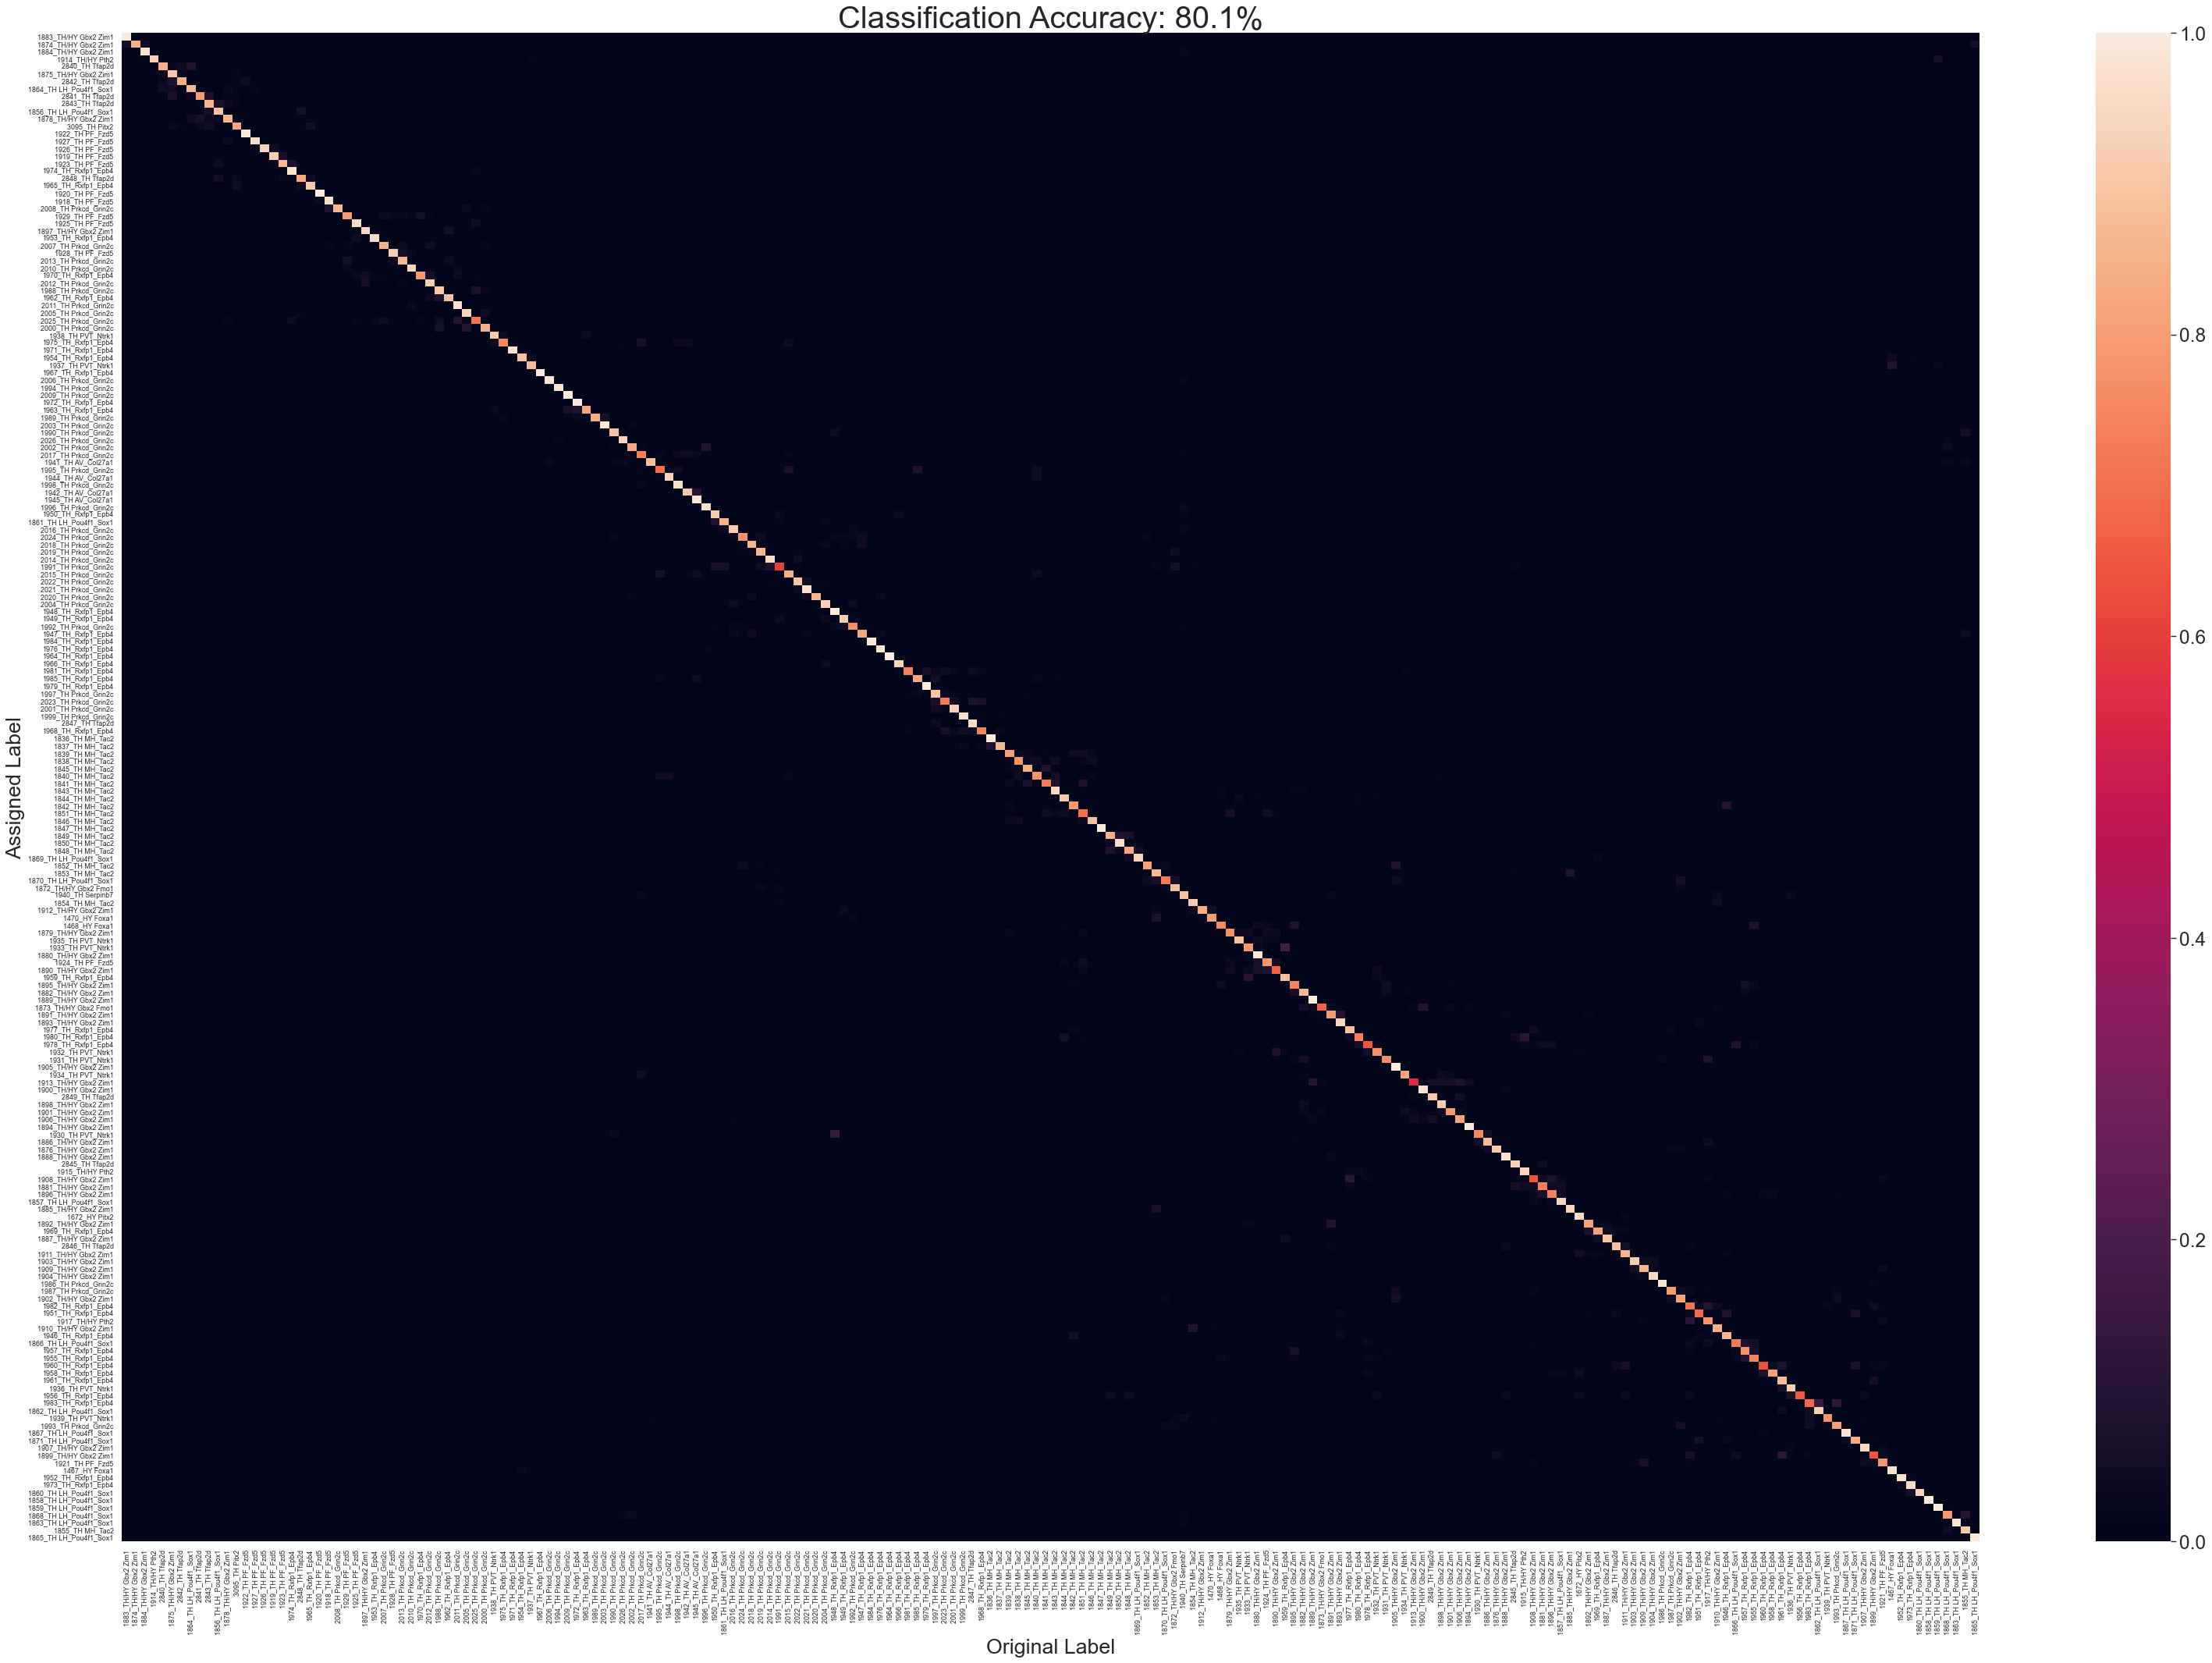

In [51]:
evalPanel(gluData,prPanel['500'],gluData.obs["cluster_label"],True);

New Labels       1467_HY Foxa1  1468_HY Foxa1  1470_HY Foxa1  1672_HY Pitx2  \
cluster_label                                                                 
1467_HY Foxa1         1.000000       0.000000       0.000000       0.000000   
1468_HY Foxa1         0.055556       0.855556       0.044444       0.000000   
1470_HY Foxa1         0.000000       0.050000       0.900000       0.000000   
1672_HY Pitx2         0.000000       0.000000       0.000000       0.939759   
1836_TH MH_Tac2       0.000000       0.000000       0.000000       0.000000   
...                        ...            ...            ...            ...   
2846_TH Tfap2d        0.000000       0.000000       0.000000       0.000000   
2847_TH Tfap2d        0.000000       0.000000       0.000000       0.000000   
2848_TH Tfap2d        0.000000       0.000000       0.000000       0.000000   
2849_TH Tfap2d        0.000000       0.000000       0.000000       0.000000   
3095_TH Pitx2         0.000000       0.000000       0.000000       0.000000   

New Labels       1836_TH MH_Tac2  1837_TH MH_Tac2  1838_TH MH_Tac2  \
cluster_label                                                        
1467_HY Foxa1           0.000000         0.000000         0.000000   
1468_HY Foxa1           0.000000         0.000000         0.000000   
1470_HY Foxa1           0.000000         0.000000         0.000000   
1672_HY Pitx2           0.000000         0.000000         0.000000   
1836_TH MH_Tac2         0.896226         0.051887         0.018868   
...                          ...              ...              ...   
2846_TH Tfap2d          0.000000         0.000000         0.000000   
2847_TH Tfap2d          0.000000         0.000000         0.000000   
2848_TH Tfap2d          0.000000         0.000000         0.000000   
2849_TH Tfap2d          0.000000         0.000000         0.000000   
3095_TH Pitx2           0.000000         0.000000         0.000000   

New Labels       1839_TH MH_Tac2  1840_TH MH_Tac2  1841_TH MH_Tac2  ...  \
cluster_label                                                       ...   
1467_HY Foxa1           0.000000              0.0              0.0  ...   
1468_HY Foxa1           0.000000              0.0              0.0  ...   
1470_HY Foxa1           0.000000              0.0              0.0  ...   
1672_HY Pitx2           0.000000              0.0              0.0  ...   
1836_TH MH_Tac2         0.033019              0.0              0.0  ...   
...                          ...              ...              ...  ...   
2846_TH Tfap2d          0.000000              0.0              0.0  ...   
2847_TH Tfap2d          0.000000              0.0              0.0  ...   
2848_TH Tfap2d          0.000000              0.0              0.0  ...   
2849_TH Tfap2d          0.000000              0.0              0.0  ...   
3095_TH Pitx2           0.000000              0.0              0.0  ...   

New Labels       2840_TH Tfap2d  2841_TH Tfap2d  2842_TH Tfap2d  \
cluster_label                                                     
1467_HY Foxa1          0.000000             0.0        0.000000   
1468_HY Foxa1          0.000000             0.0        0.000000   
1470_HY Foxa1          0.000000             0.0        0.000000   
1672_HY Pitx2          0.000000             0.0        0.000000   
1836_TH MH_Tac2        0.000000             0.0        0.000000   
...                         ...             ...             ...   
2846_TH Tfap2d         0.000000             0.0        0.000000   
2847_TH Tfap2d         0.000000             0.0        0.000000   
2848_TH Tfap2d         0.017241             0.0        0.000000   
2849_TH Tfap2d         0.000000             0.0        0.000000   
3095_TH Pitx2          0.000000             0.0        0.033333   

New Labels       2843_TH Tfap2d  2845_TH Tfap2d  2846_TH Tfap2d  \
cluster_label                                                     
1467_HY Foxa1               0.0             0.0        0.000000   
1468_HY Foxa

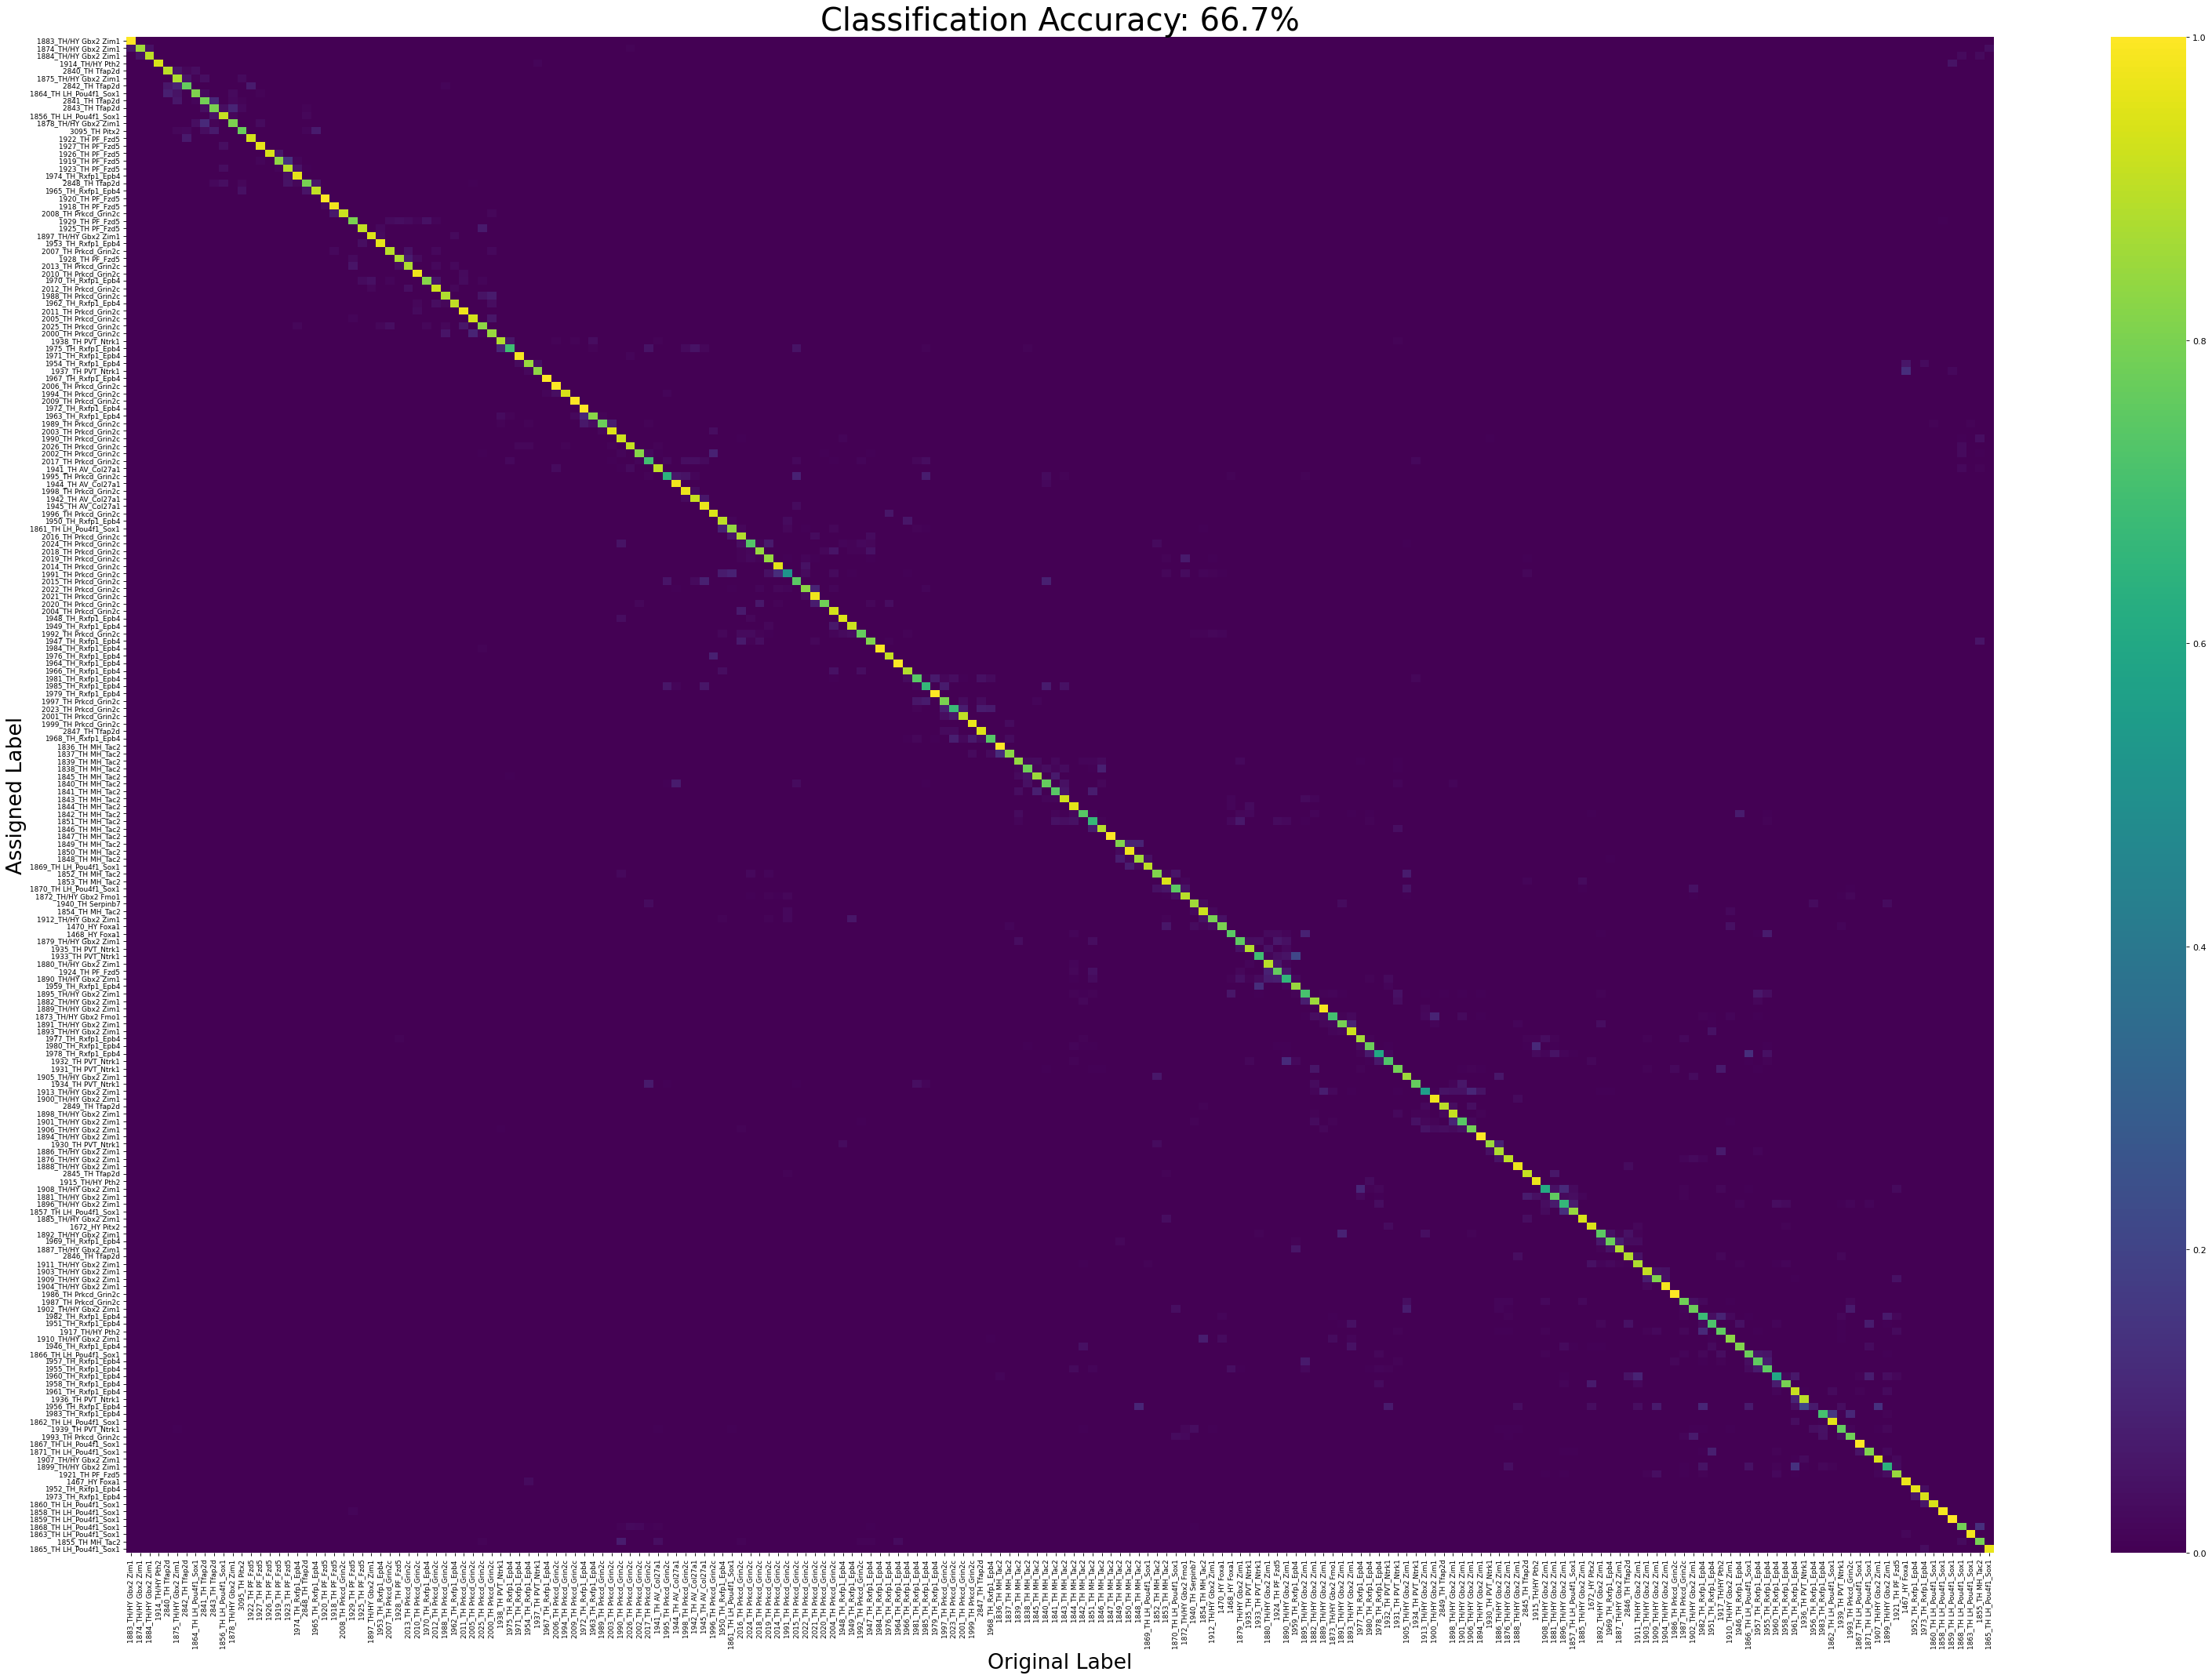

In [403]:
# Check how a particular gene panel does w/ confusion matrix

[a,b, c] = evalPanel(gluData,panelWilcoxon[1],gluData.obs["cluster_label"],True);
c

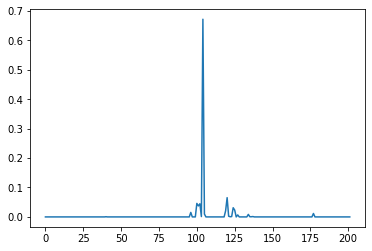

In [410]:
# Try to understand where individual cluster classifications are going wrong
pd.Series(np.diag(c)).idxmin()
c.iloc[132,:]
# plt.plot(range(202),np.diag(c))
# pd.unique(cluster)
# plt.plot(range(202),c.iloc[132,:])
# plt.plot(range(202),c["1956_TH_Rxfp1_Epb4"])
plt.plot(range(202),c.loc["1938_TH PVT_Ntrk1"])
# plt.ylim([0, 1])
# c

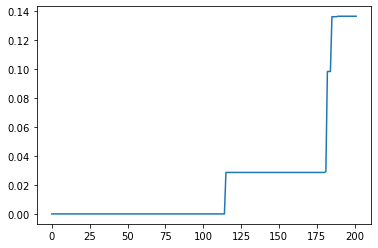

In [272]:
plt.plot(range(202),np.cumsum(c.iloc[:,182]))

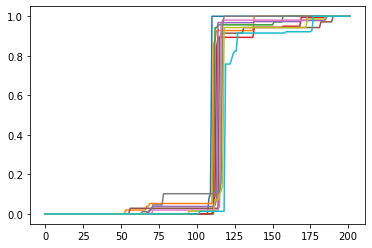

In [263]:
x = 11
for i in range(x * 10,(x+1)*10):
    plt.plot(range(202),np.cumsum(c.iloc[i,:]))

New Labels
1467_HY Foxa1      0.0
1468_HY Foxa1      0.0
1470_HY Foxa1      0.0
1672_HY Pitx2      0.0
1836_TH MH_Tac2    0.0
                  ... 
2846_TH Tfap2d     0.0
2847_TH Tfap2d     0.0
2848_TH Tfap2d     0.0
2849_TH Tfap2d     0.0
3095_TH Pitx2      0.0
Name: 2013_TH Prkcd_Grin2c, Length: 202, dtype: float64

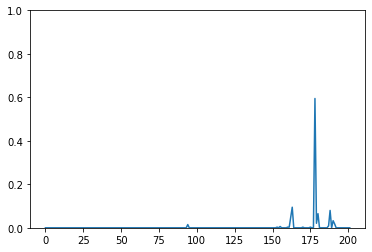

In [255]:
indx = 178
plt.plot(range(202),c.iloc[indx,:])
plt.ylim([0, 1])
c.iloc[indx,:]

In [271]:
pd.Series(np.diag(c)).sort_values()

182    0.068966
71     0.516588
140    0.555245
178    0.594675
135    0.600218
         ...   
48     1.000000
187    1.000000
49     1.000000
83     1.000000
0      1.000000
Length: 202, dtype: float64

In [239]:
c

New Labels       1467_HY Foxa1  1468_HY Foxa1  1470_HY Foxa1  1672_HY Pitx2  \
cluster_label                                                                 
1467_HY Foxa1         1.000000       0.000000       0.000000       0.000000   
1468_HY Foxa1         0.055556       0.855556       0.044444       0.000000   
1470_HY Foxa1         0.000000       0.050000       0.900000       0.000000   
1672_HY Pitx2         0.000000       0.000000       0.000000       0.939759   
1836_TH MH_Tac2       0.000000       0.000000       0.000000       0.000000   
...                        ...            ...            ...            ...   
2846_TH Tfap2d        0.000000       0.000000       0.000000       0.000000   
2847_TH Tfap2d        0.000000       0.000000       0.000000       0.000000   
2848_TH Tfap2d        0.000000       0.000000       0.000000       0.000000   
2849_TH Tfap2d        0.000000       0.000000       0.000000       0.000000   
3095_TH Pitx2         0.000000       0.000000       0.000000       0.000000   

New Labels       1836_TH MH_Tac2  1837_TH MH_Tac2  1838_TH MH_Tac2  \
cluster_label                                                        
1467_HY Foxa1           0.000000         0.000000         0.000000   
1468_HY Foxa1           0.000000         0.000000         0.000000   
1470_HY Foxa1           0.000000         0.000000         0.000000   
1672_HY Pitx2           0.000000         0.000000         0.000000   
1836_TH MH_Tac2         0.896226         0.051887         0.018868   
...                          ...              ...              ...   
2846_TH Tfap2d          0.000000         0.000000         0.000000   
2847_TH Tfap2d          0.000000         0.000000         0.000000   
2848_TH Tfap2d          0.000000         0.000000         0.000000   
2849_TH Tfap2d          0.000000         0.000000         0.000000   
3095_TH Pitx2           0.000000         0.000000         0.000000   

New Labels       1839_TH MH_Tac2  1840_TH MH_Tac2  1841_TH MH_Tac2  ...  \
cluster_label                                                       ...   
1467_HY Foxa1           0.000000              0.0              0.0  ...   
1468_HY Foxa1           0.000000              0.0              0.0  ...   
1470_HY Foxa1           0.000000              0.0              0.0  ...   
1672_HY Pitx2           0.000000              0.0              0.0  ...   
1836_TH MH_Tac2         0.033019              0.0              0.0  ...   
...                          ...              ...              ...  ...   
2846_TH Tfap2d          0.000000              0.0              0.0  ...   
2847_TH Tfap2d          0.000000              0.0              0.0  ...   
2848_TH Tfap2d          0.000000              0.0              0.0  ...   
2849_TH Tfap2d          0.000000              0.0              0.0  ...   
3095_TH Pitx2           0.000000              0.0              0.0  ...   

New Labels       2840_TH Tfap2d  2841_TH Tfap2d  2842_TH Tfap2d  \
cluster_label                                                     
1467_HY Foxa1          0.000000             0.0        0.000000   
1468_HY Foxa1          0.000000             0.0        0.000000   
1470_HY Foxa1          0.000000             0.0        0.000000   
1672_HY Pitx2          0.000000             0.0        0.000000   
1836_TH MH_Tac2        0.000000             0.0        0.000000   
...                         ...             ...             ...   
2846_TH Tfap2d         0.000000             0.0        0.000000   
2847_TH Tfap2d         0.000000             0.0        0.000000   
2848_TH Tfap2d         0.017241             0.0        0.000000   
2849_TH Tfap2d         0.000000             0.0        0.000000   
3095_TH Pitx2          0.000000             0.0        0.033333   

New Labels       2843_TH Tfap2d  2845_TH Tfap2d  2846_TH Tfap2d  \
cluster_label                                                     
1467_HY Foxa1               0.0             0.0        0.000000   
1468_HY Foxa

New Labels
1467_HY Foxa1      0.055556
1468_HY Foxa1      0.855556
1470_HY Foxa1      0.044444
1672_HY Pitx2      0.000000
1836_TH MH_Tac2    0.000000
                     ...   
2846_TH Tfap2d     0.000000
2847_TH Tfap2d     0.000000
2848_TH Tfap2d     0.000000
2849_TH Tfap2d     0.000000
3095_TH Pitx2      0.033333
Name: 1468_HY Foxa1, Length: 202, dtype: float64

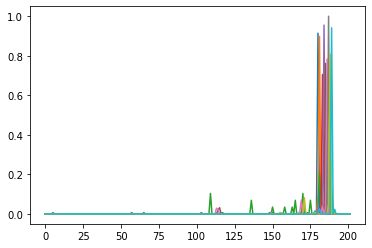

In [226]:
x = 18
for i in range(x * 10,(x+1)*10):
    plt.plot(range(202),c.iloc[i,:])

## Cluster size vs accuracy comparison

In [10]:
def plotClusterSize(geneData,genePanel,cluster):
    """ Function to plot gene panel accuracy as function of cluster size """
    from sklearn.neighbors import NearestCentroid
    import matplotlib.pyplot as plt
    
    # Get size of each cluster
    clTypes = cluster.unique()
    clCounts = pd.Series([sum(cluster == name) for name in clTypes], index = clTypes, name="Count")
    
    # Project data onto input gene panel, then establish a nearest centroid classifier
    projGenes = geneData[:,genePanel].X
    nn = NearestCentroid()
    nn.fit(projGenes,cluster)
  
    # Get accuracy for each cluster type
    clAcc = pd.Series( name = "Accuracy")
    for name in clTypes:
        clIndx = cluster == name
        clAcc[name] = nn.score(projGenes[clIndx,:],cluster[clIndx])

    results = clCounts.to_frame().join(clAcc).sort_values(by = "Accuracy", ascending = False)
    
    # Plot correlation between cluster size and accuracy
    fig, ax = plt.subplots()
    plt.plot(clCounts,clAcc,'og',markeredgecolor = 'k')
    ax.set_ylim(-0.02, 1.02)
    plt.grid()
    plt.xlabel("Cluster Size")
    plt.ylabel("Classification Accuracy")
    plt.title("Cluster Size vs Accuracy")
    return ax, results

C:\Users\mathew.summers\AppData\Local\Temp\ipykernel_8200\3260360475.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clAcc = pd.Series( name = "Accuracy")


(<AxesSubplot:title={'center':'Cluster Size vs Accuracy'}, xlabel='Cluster Size', ylabel='Classification Accuracy'>,
                       Count  Accuracy
 1881_TH/HY Gbx2 Zim1     38  1.000000
 1973_TH_Rxfp1_Epb4       34  1.000000
 1853_TH MH_Tac2          20  1.000000
 1845_TH MH_Tac2          43  1.000000
 1882_TH/HY Gbx2 Zim1     60  1.000000
 ...                     ...       ...
 2025_TH Prkcd_Grin2c   2061  0.641436
 1988_TH Prkcd_Grin2c    290  0.641379
 2013_TH Prkcd_Grin2c    338  0.630178
 1904_TH/HY Gbx2 Zim1    211  0.601896
 1975_TH_Rxfp1_Epb4      715  0.549650
 
 [202 rows x 2 columns])

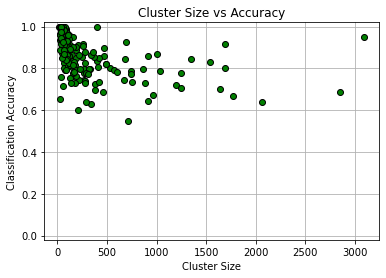

In [114]:
plotClusterSize(gluData,prPanel['500'],gluData.obs["cluster_label"])

C:\Users\mathew.summers\AppData\Local\Temp\ipykernel_16316\1586013382.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clAcc = pd.Series( name = "Accuracy")


(<AxesSubplot:title={'center':'Cluster Size vs Accuracy'}, xlabel='Cluster Size', ylabel='Classification Accuracy'>,
                       Count  Accuracy
 1878_TH/HY Gbx2 Zim1     55  1.000000
 1882_TH/HY Gbx2 Zim1     60  1.000000
 1917_TH/HY Pth2          27  1.000000
 1881_TH/HY Gbx2 Zim1     38  1.000000
 1467_HY Foxa1            40  1.000000
 ...                     ...       ...
 2013_TH Prkcd_Grin2c    338  0.576923
 1988_TH Prkcd_Grin2c    290  0.565517
 1904_TH/HY Gbx2 Zim1    211  0.507109
 1975_TH_Rxfp1_Epb4      715  0.446154
 2017_TH Prkcd_Grin2c     29  0.379310
 
 [202 rows x 2 columns])

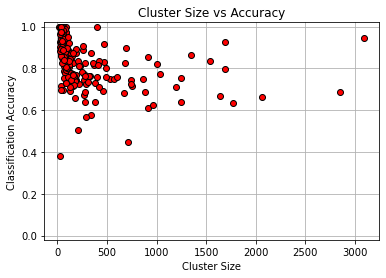

In [27]:
plotClusterSize(gluData,prPanel[202],gluData.obs["cluster_label"])

C:\Users\mathew.summers\AppData\Local\Temp\ipykernel_2632\1586013382.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clAcc = pd.Series( name = "Accuracy")


(<AxesSubplot:title={'center':'Cluster Size vs Accuracy'}, xlabel='Cluster Size', ylabel='Classification Accuracy'>,
                       Count  Accuracy
 1981_TH_Rxfp1_Epb4       50  1.000000
 2845_TH Tfap2d           81  1.000000
 1882_TH/HY Gbx2 Zim1     60  1.000000
 1907_TH/HY Gbx2 Zim1     39  1.000000
 1853_TH MH_Tac2          20  1.000000
 ...                     ...       ...
 1970_TH_Rxfp1_Epb4      918  0.563181
 1988_TH Prkcd_Grin2c    290  0.555172
 1904_TH/HY Gbx2 Zim1    211  0.545024
 2013_TH Prkcd_Grin2c    338  0.497041
 1975_TH_Rxfp1_Epb4      715  0.493706
 
 [202 rows x 2 columns])

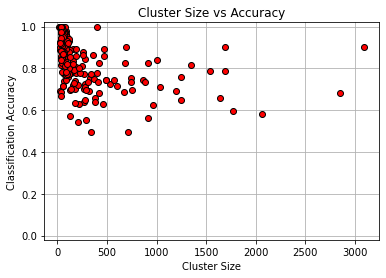

In [53]:
plotClusterSize(gluData,list(y & z),gluData.obs["cluster_label"])

## Plot dendrogram

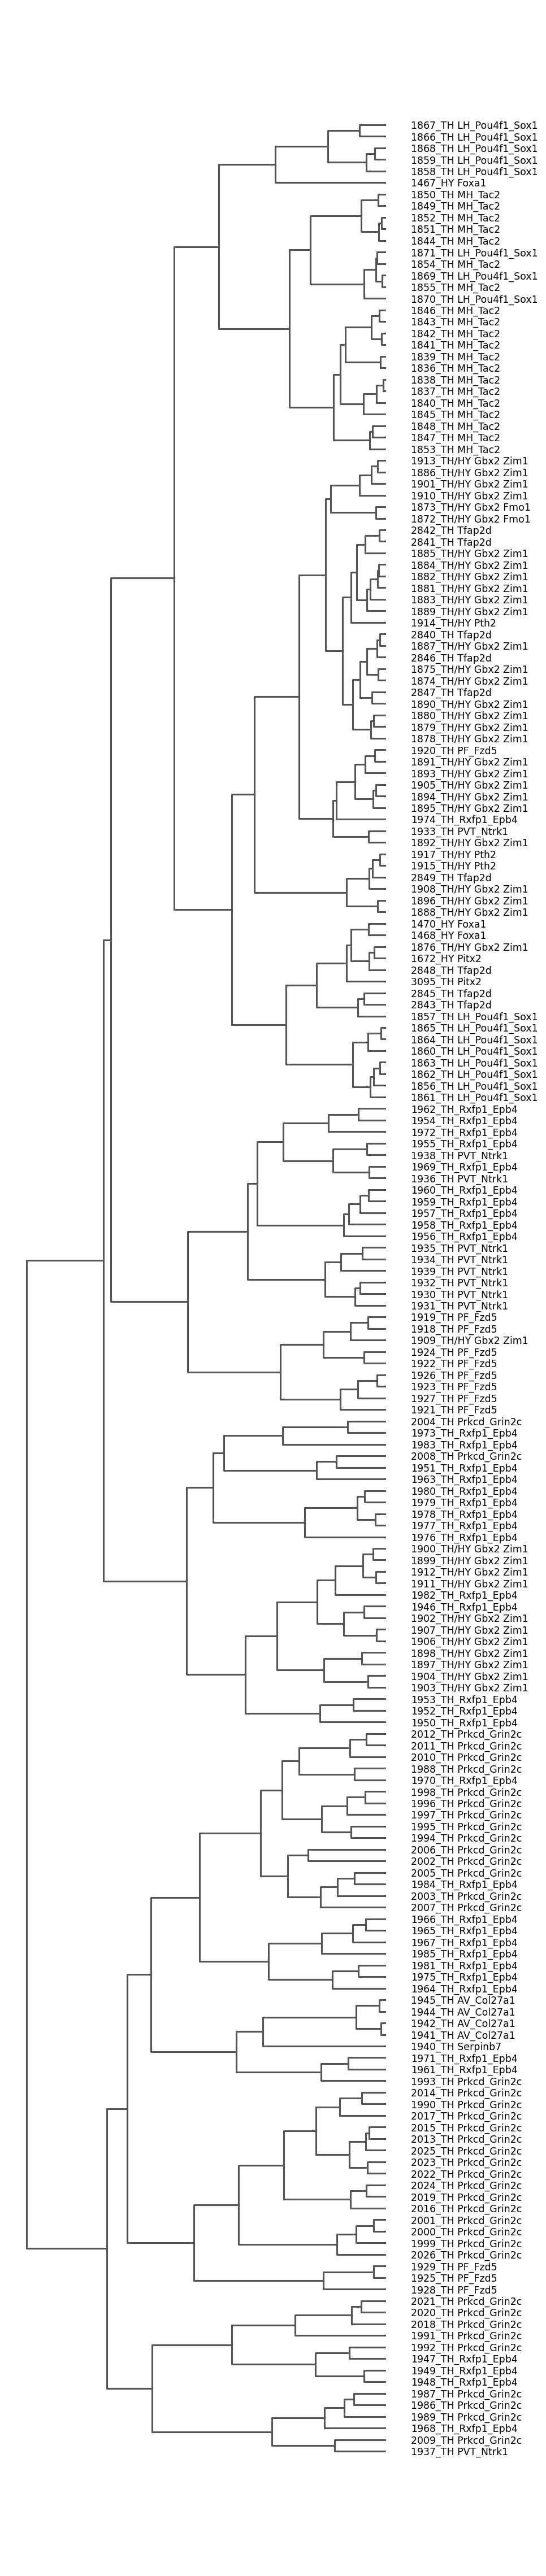

<AxesSubplot:>

In [111]:
sc.tl.dendrogram(gluData,"cluster_label")
plt.figure(figsize=(6, 40), dpi=150)
ax = plt.subplot(1,1, 1)
sc.pl.dendrogram(gluData,"cluster_label",orientation = 'left', ax= ax)

<AxesSubplot:>

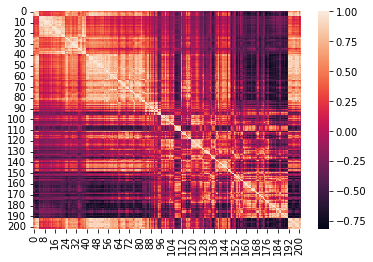

In [112]:
sns.heatmap(gluData.uns["dendrogram_cluster_label"]["correlation_matrix"])

[Text(0.5, 1.0, '32 Genes')]

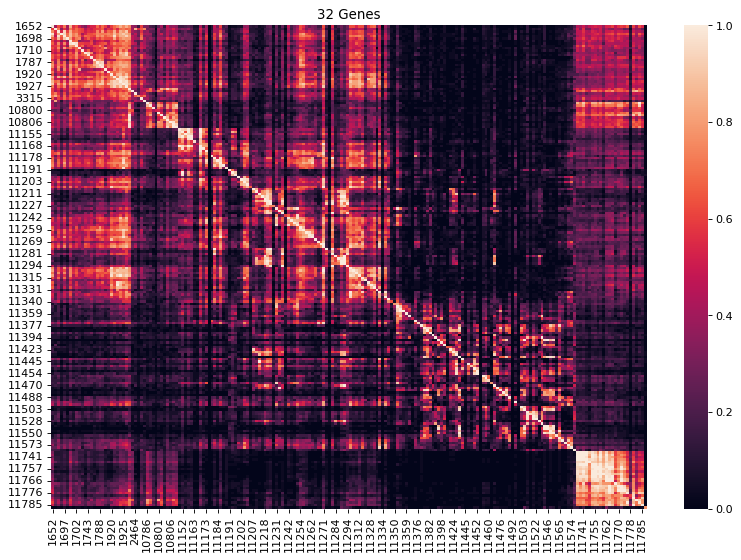

In [71]:
# Plot confusion matrices by "marker gene overlap", e.g. is there any detected expression in a given cell?
pThresh = 1e-10
markerOverlap = sc.tl.marker_gene_overlap(gluData,markerGenes,method="overlap_count", normalize = "reference", adj_pval_threshold = pThresh, inplace=False)
plt.figure(figsize=(12, 8), dpi=80)
sns.heatmap(markerOverlap).set(title="32 Genes")

## Intersection of gene panels

In [11]:
# Some matplotlib compatibility issues - this wrecks the default color settings
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles

NameError: name 'fbPanel' is not defined

In [10]:
# Convert each panel to a set, assess which elements overlap between panels
indx = '500'

wlSet = set(wlPanel['448'])
prSet = set(prPanel[indx])
gfSet = set(gfPanel[indx])
svSet = set(svPanel[indx])
fbSet = set(fbPanel[indx])
rSet = set(rPanel[indx])

NameError: name 'fbPanel' is not defined

In [66]:
panelOverlap = lambda a, b : len(a & b) / len(a | b)

panelOverlap(svSet,gfSet)

0.3679890560875513

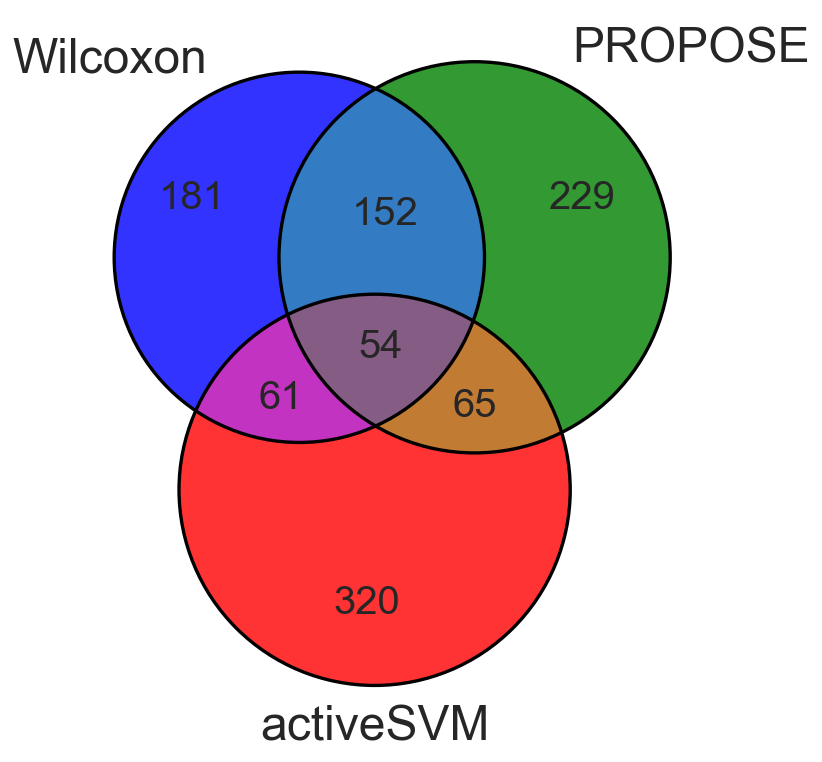

In [122]:
plt.figure(figsize=(12, 8), dpi=120)
venn3(subsets = (wlSet,prSet,svSet), set_labels = ('Wilcoxon','PROPOSE','activeSVM'),alpha = .8,
      set_colors=['blue','green','red']);
venn3_circles(subsets = (wlSet,prSet,svSet), lw=2);

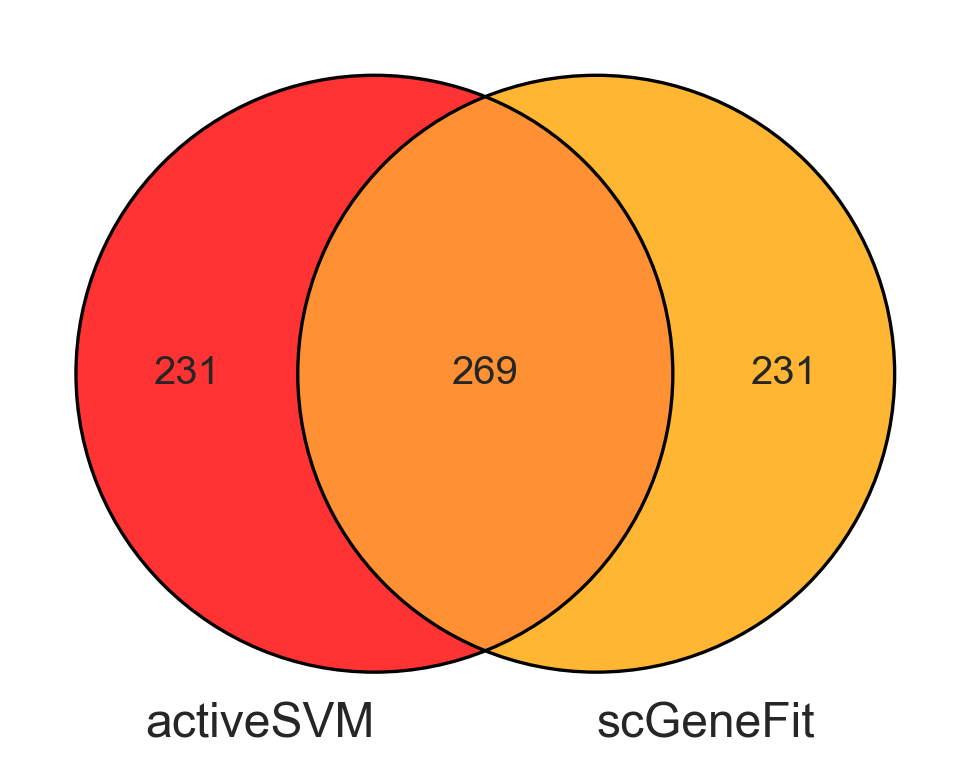

In [132]:
plt.figure(figsize=(12, 8), dpi=120)
venn2(subsets = (svSet,gfSet), set_labels = ('activeSVM','scGeneFit'),alpha = .8,
      set_colors=['red','orange']);
venn2_circles(subsets = (svSet,gfSet), lw=2);

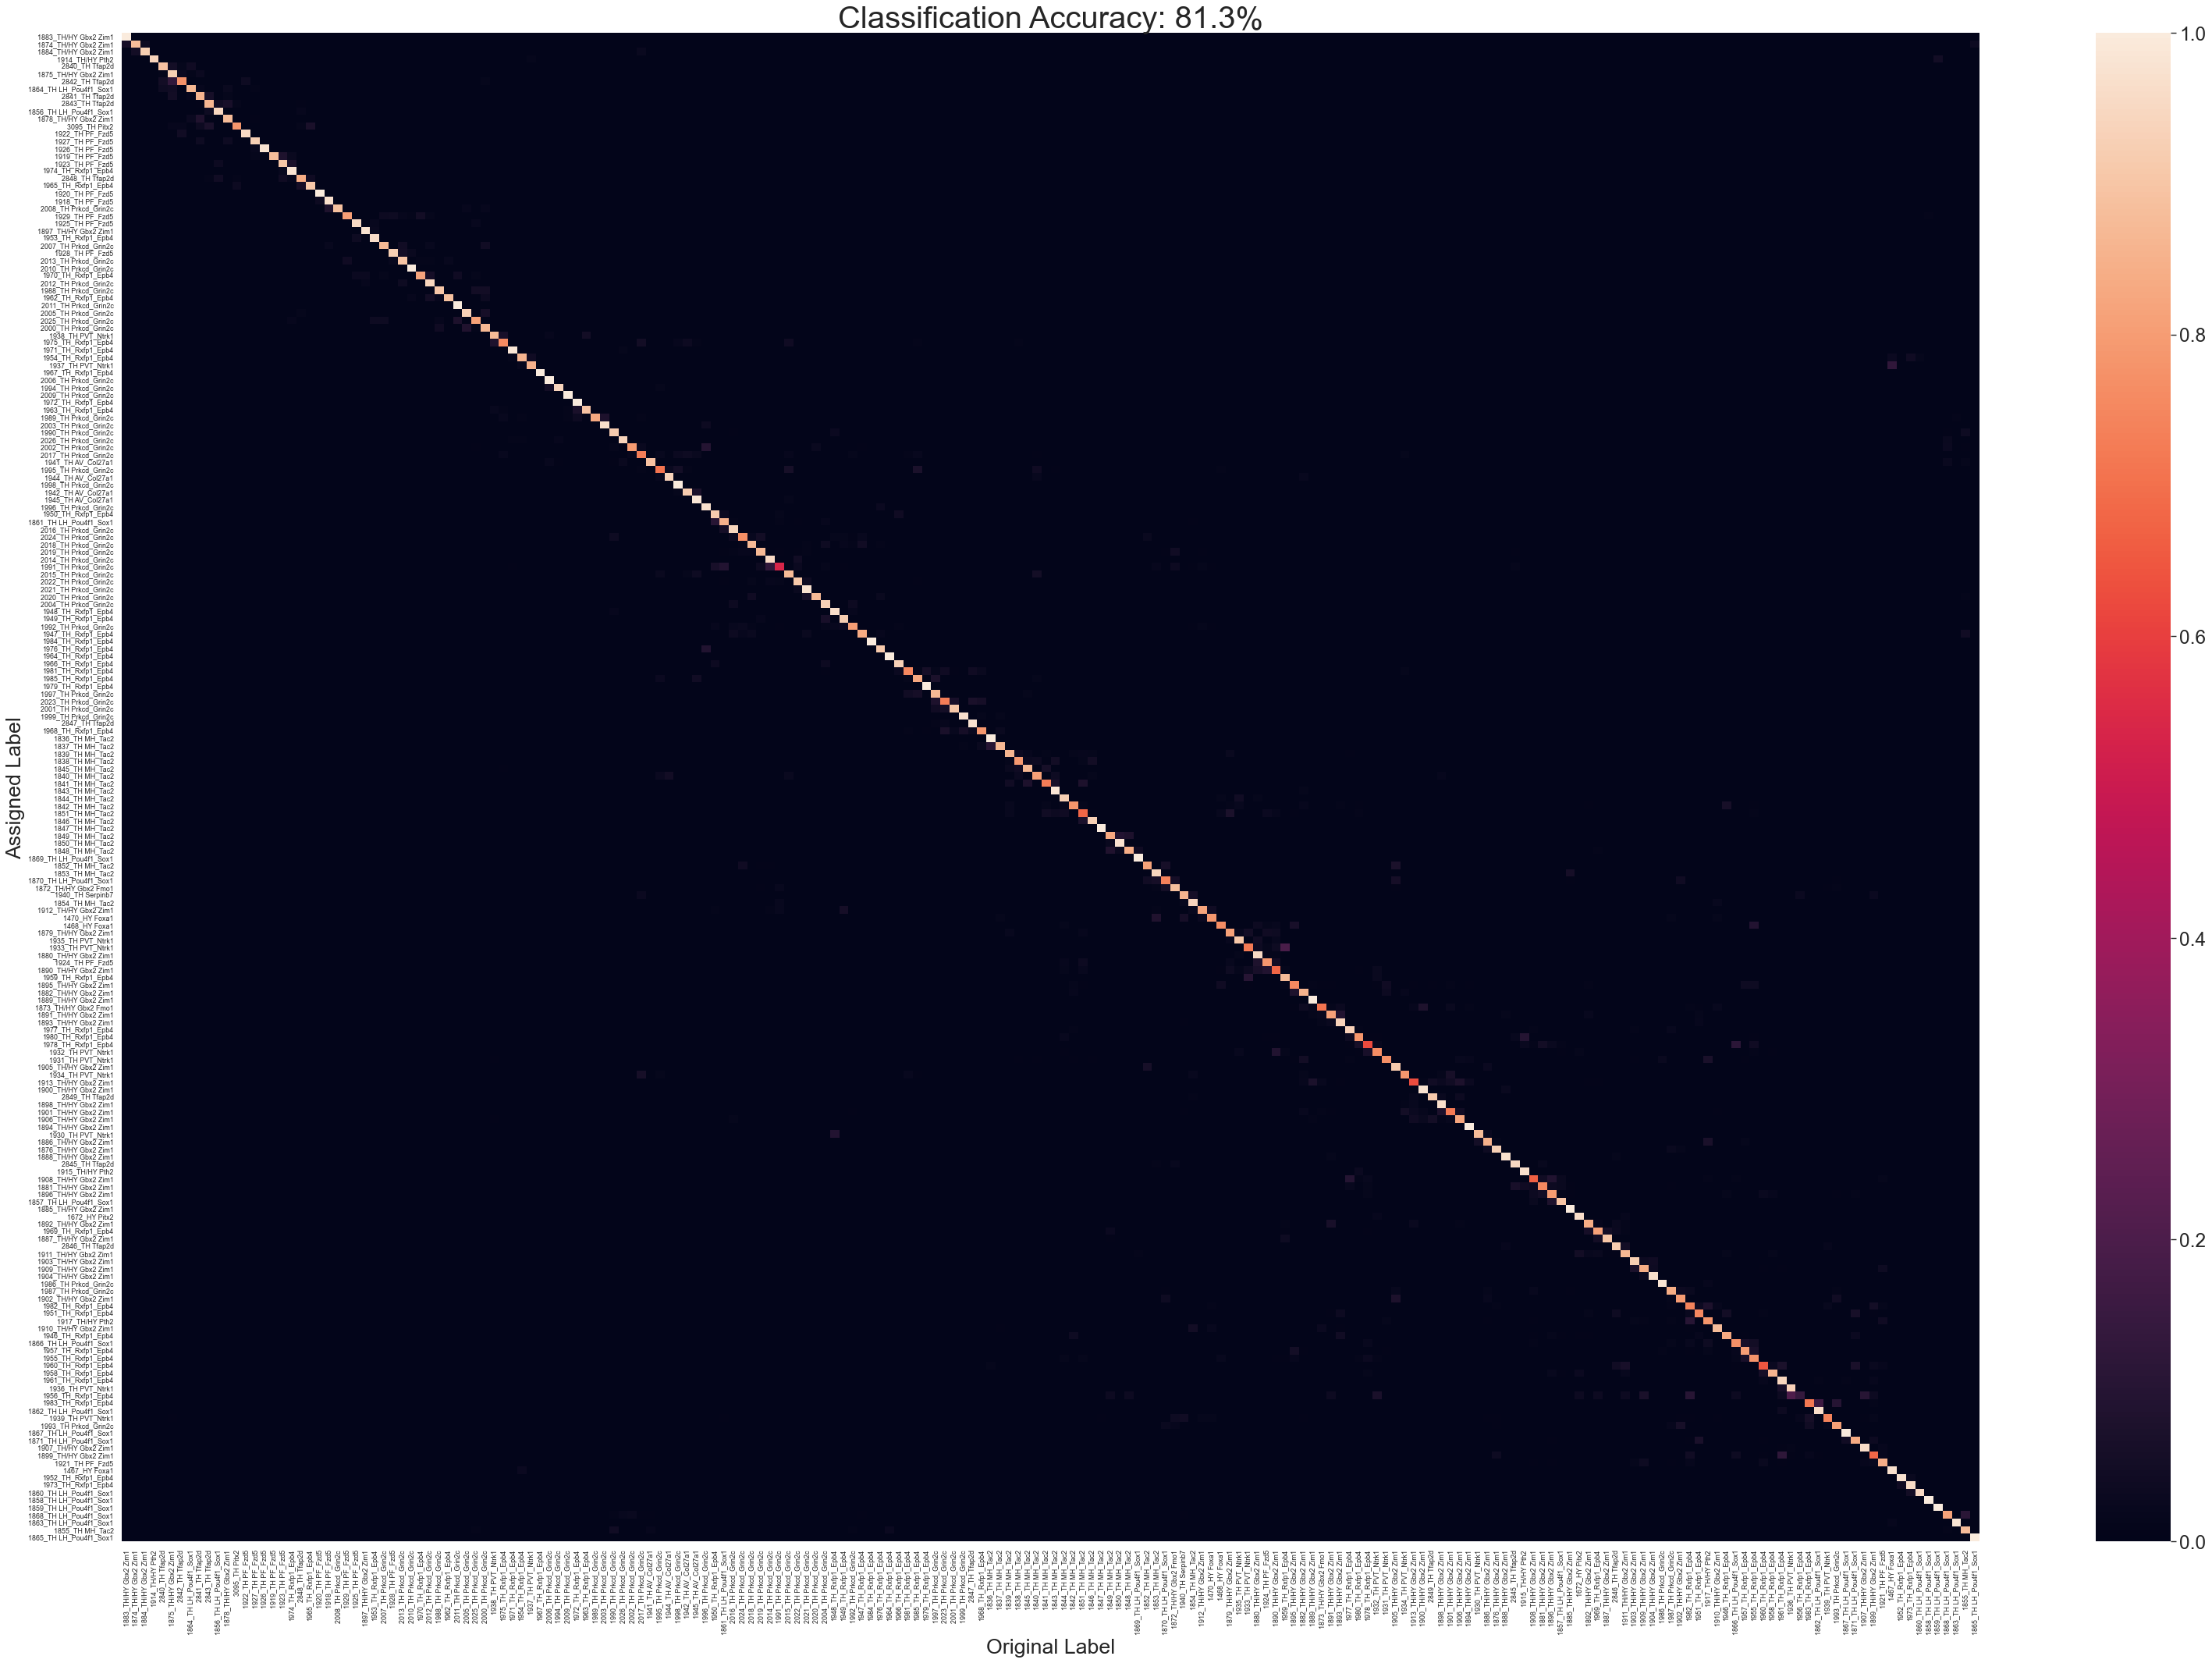

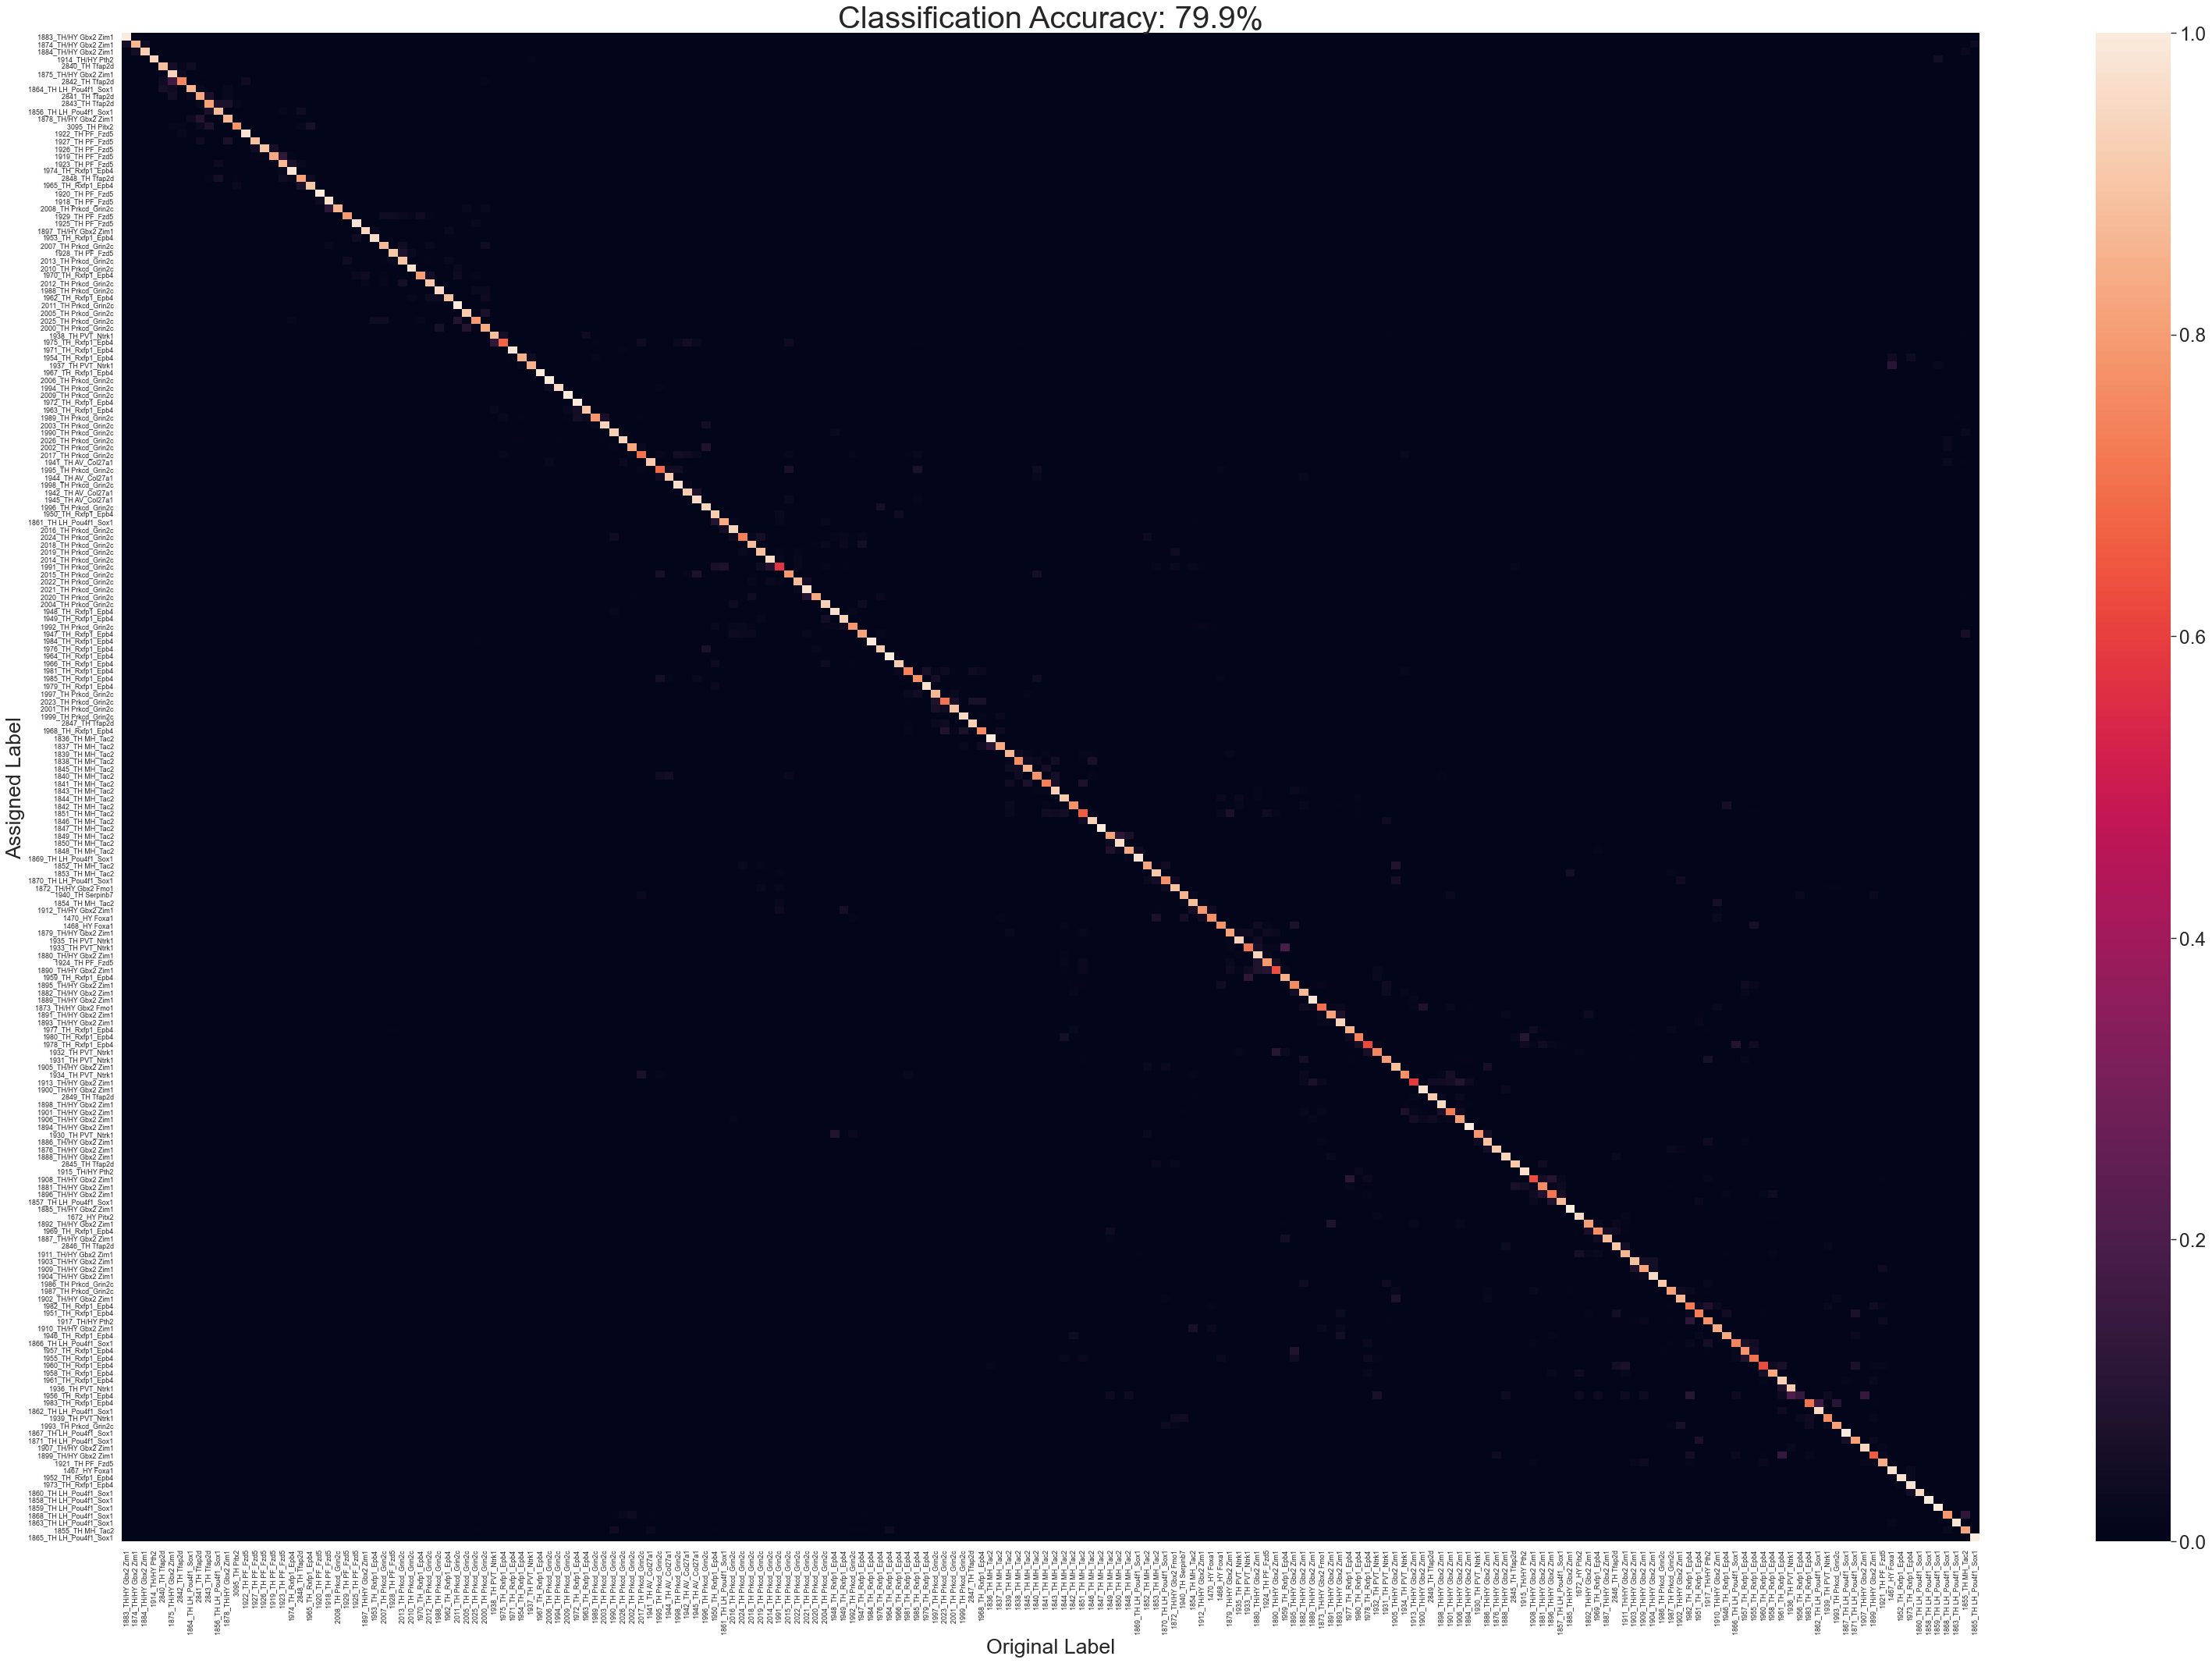

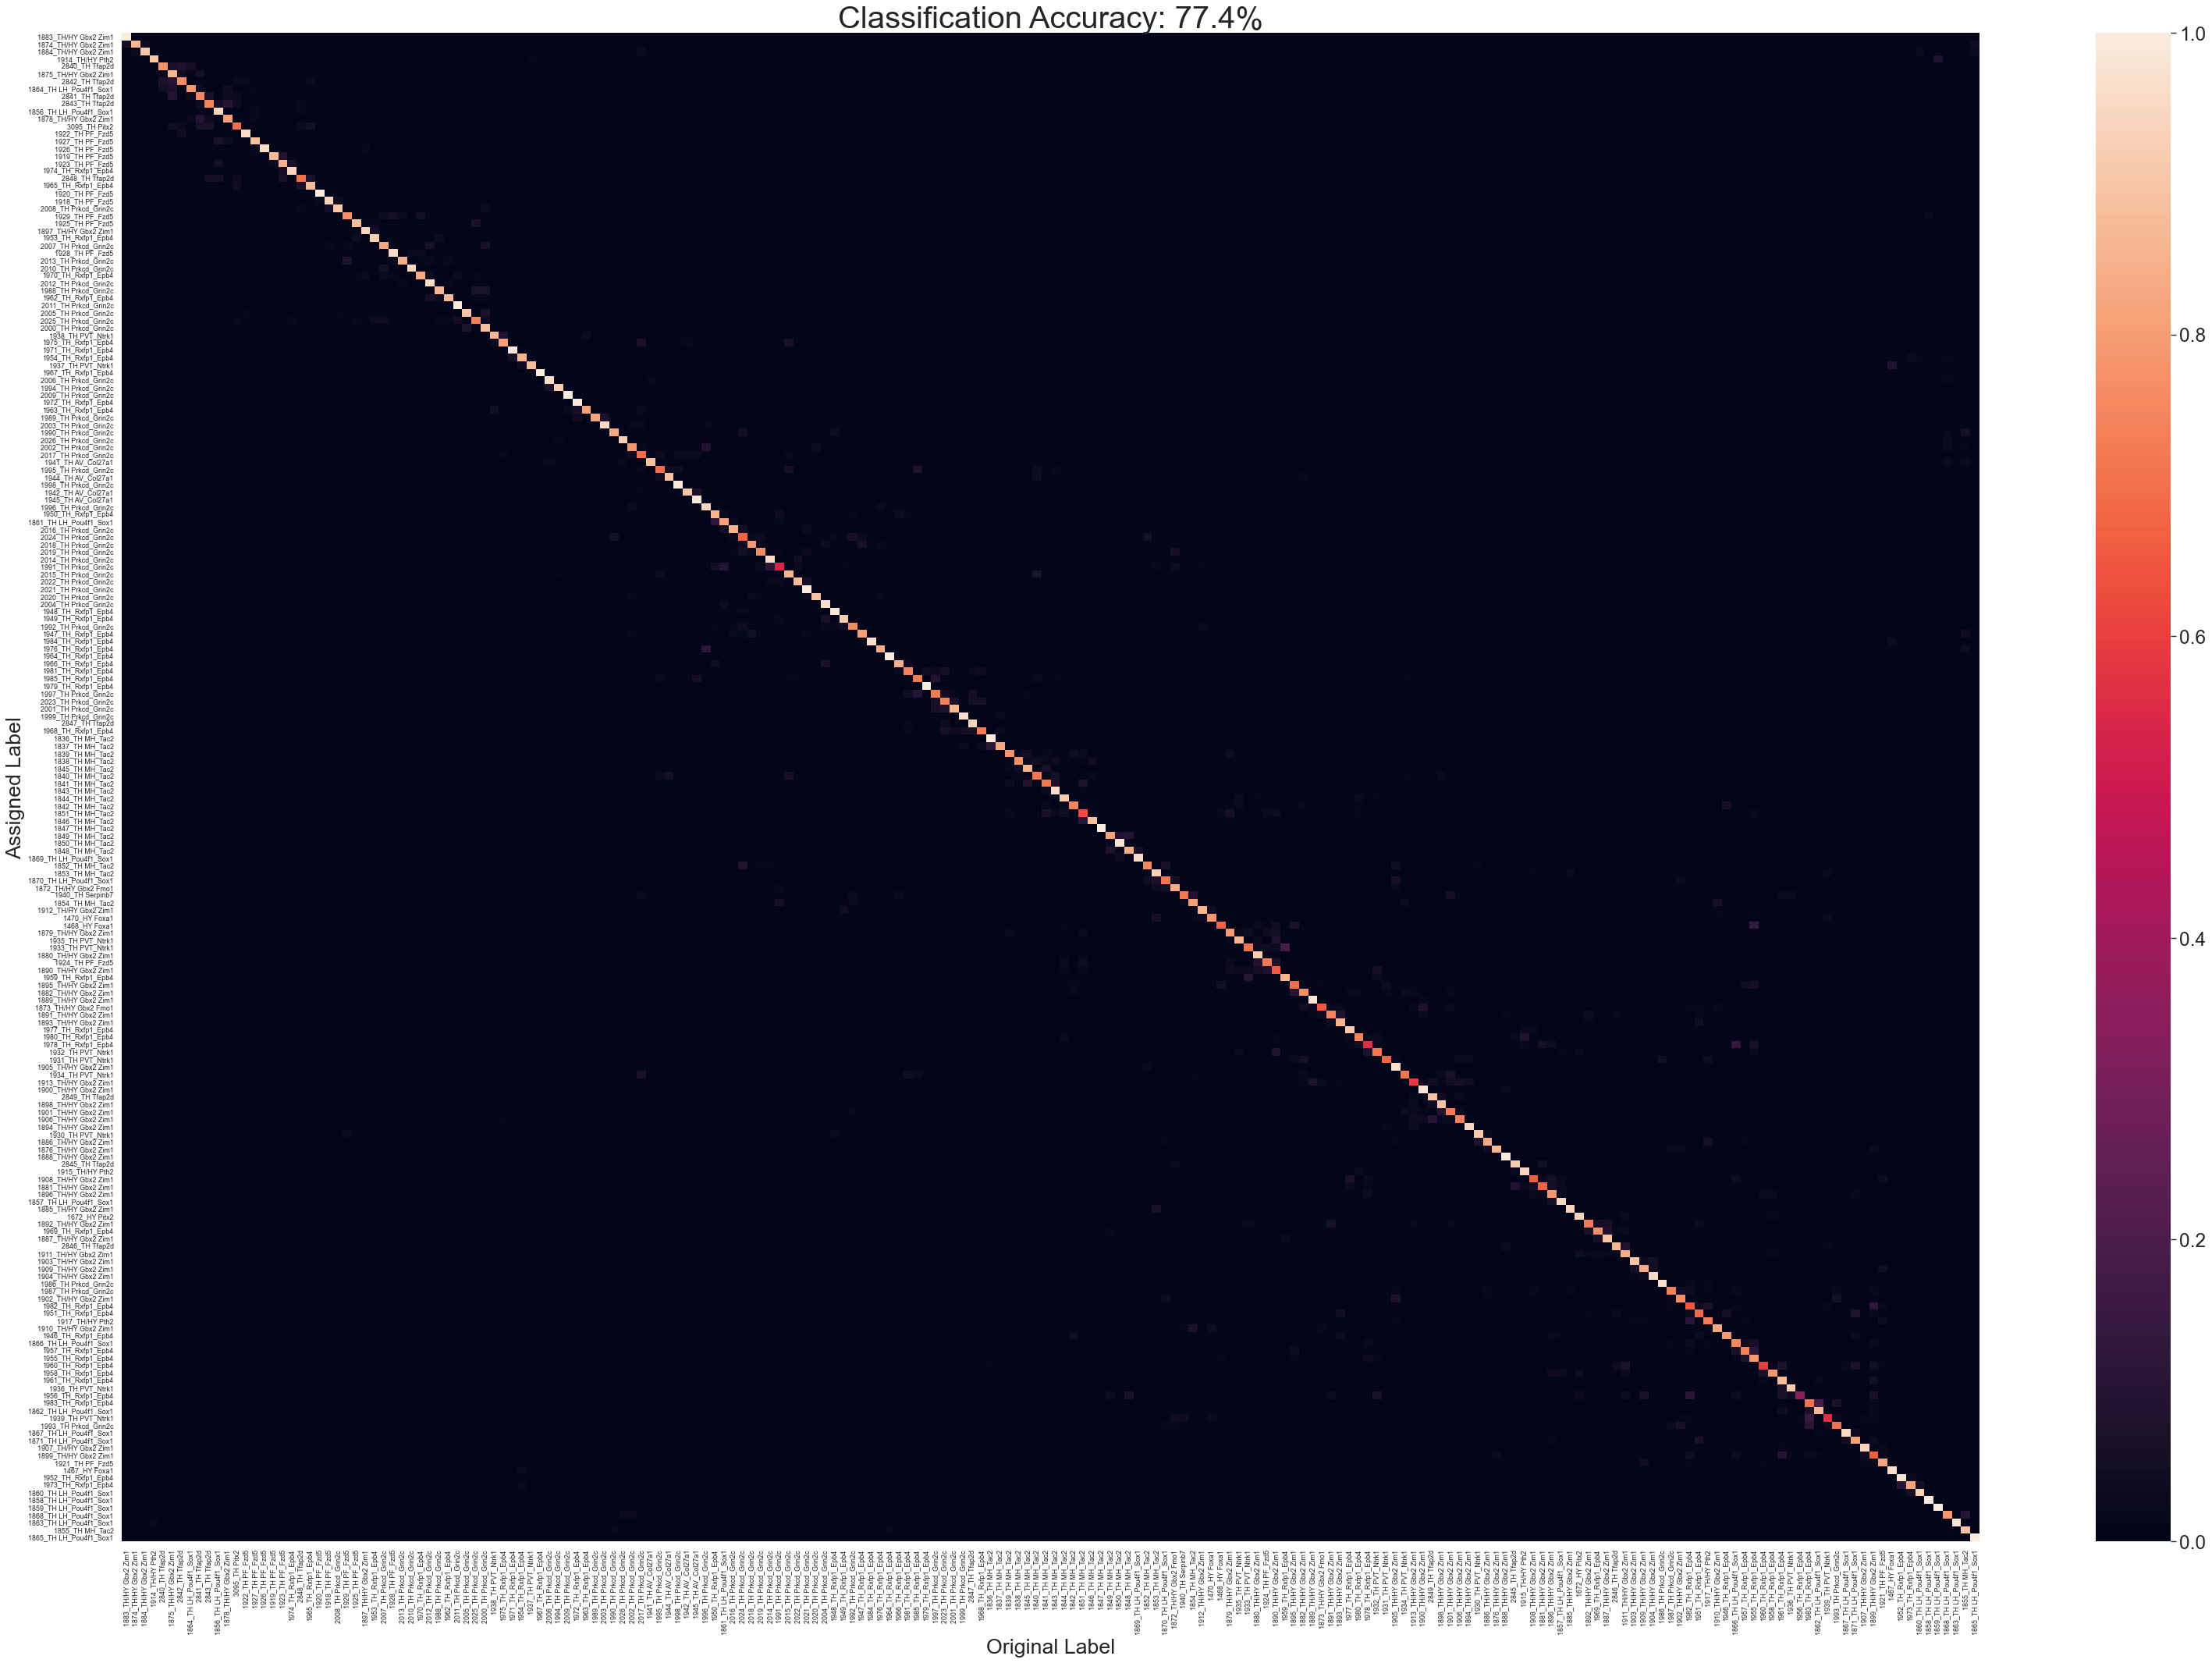

In [141]:
# Plot accuracy of non-overlapping genes
[accuracyBaseline,_,baseMatrix] = evalPanel(gluData,list(svSet),gluData.obs["cluster_label"],True);
[accuracyOverlap,_,overMatrix] = evalPanel(gluData,list(svSet & gfSet),gluData.obs["cluster_label"],True);
[accuracyNonOverlapping,_,nonMatrix] = evalPanel(gluData,list(svSet - gfSet),gluData.obs["cluster_label"],True);

Text(0.5, 1.0, 'Panel Subset Accuracy')

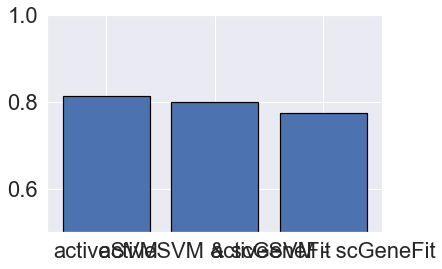

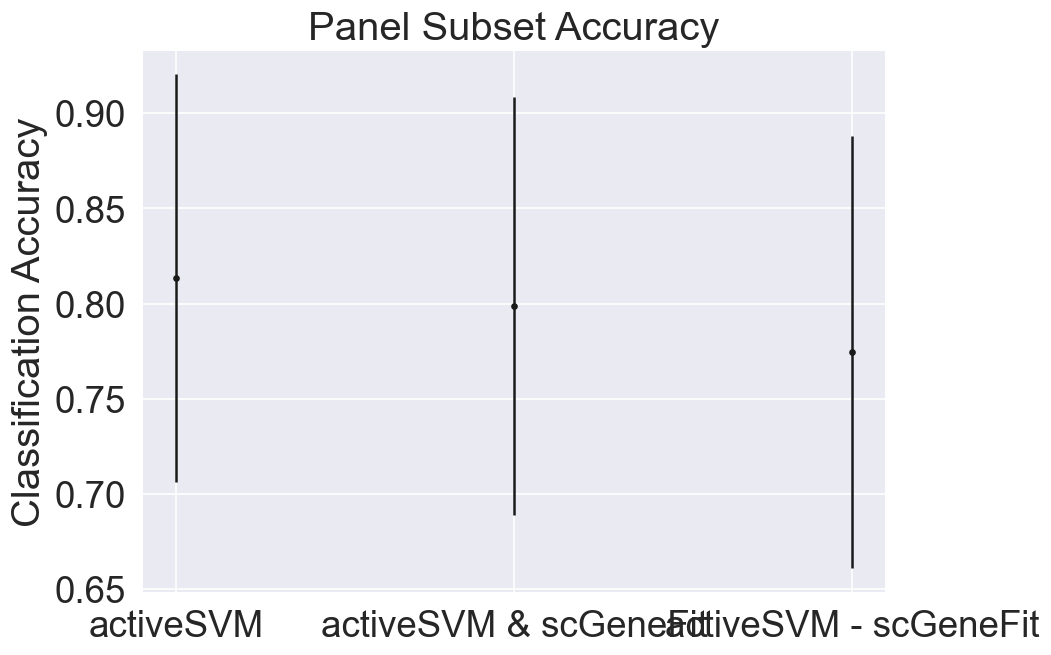

In [143]:
# Plot error bar comparison of each 500 gene panel
# Compute standard deviation
baseError = np.std(np.diag(baseMatrix))
overError = np.std(np.diag(overMatrix))
nonError = np.std(np.diag(nonMatrix))

# Make plots
fig, ax = plt.subplots()
plt.figure(figsize=(8, 6), dpi=120)
# ax.bar(["Wilcoxon","PROPOSE","scGeneFit","activeSVM","MERSCOPE"],[wilAccuracy[4],prAccuracy,gfAccuracy,svAccuracy,mrAccuracy],
#       edgecolor = 'black',linewidth = 2)
ax.bar(['activeSVM','activeSVM & scGeneFit','activeSVM - scGeneFit'],[accuracyBaseline,accuracyOverlap,accuracyNonOverlapping],
       edgecolor = 'black', linewidth = 1.2)
plt.errorbar(['activeSVM','activeSVM & scGeneFit','activeSVM - scGeneFit'],
             [accuracyBaseline,accuracyOverlap,accuracyNonOverlapping],
             yerr = [baseError, overError, nonError], fmt = '.k')
ax.set_ylim(0.5, 1)
plt.ylabel("Classification Accuracy")
plt.title("Panel Subset Accuracy")

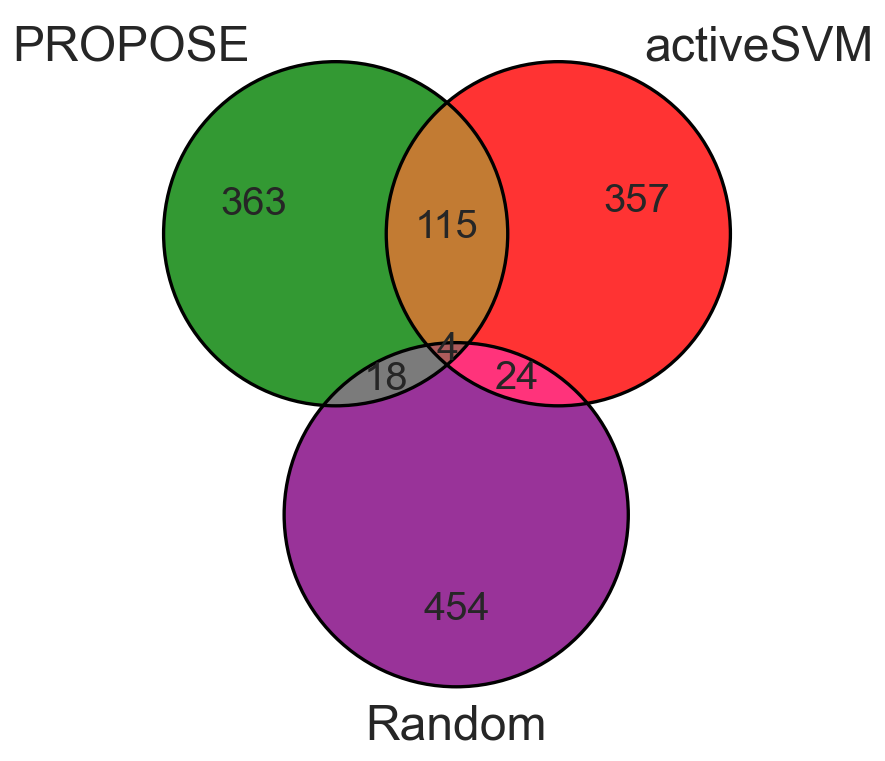

In [144]:
plt.figure(figsize=(12, 8), dpi=120)
venn3(subsets = (prSet,svSet,rSet), set_labels = ('PROPOSE', 'activeSVM','Random'),alpha = .8,
      set_colors=['green','red','purple']);
venn3_circles(subsets = (prSet,svSet,rSet), lw=2);

Text(0.5, 1.0, 'Panel Subset Accuracy')

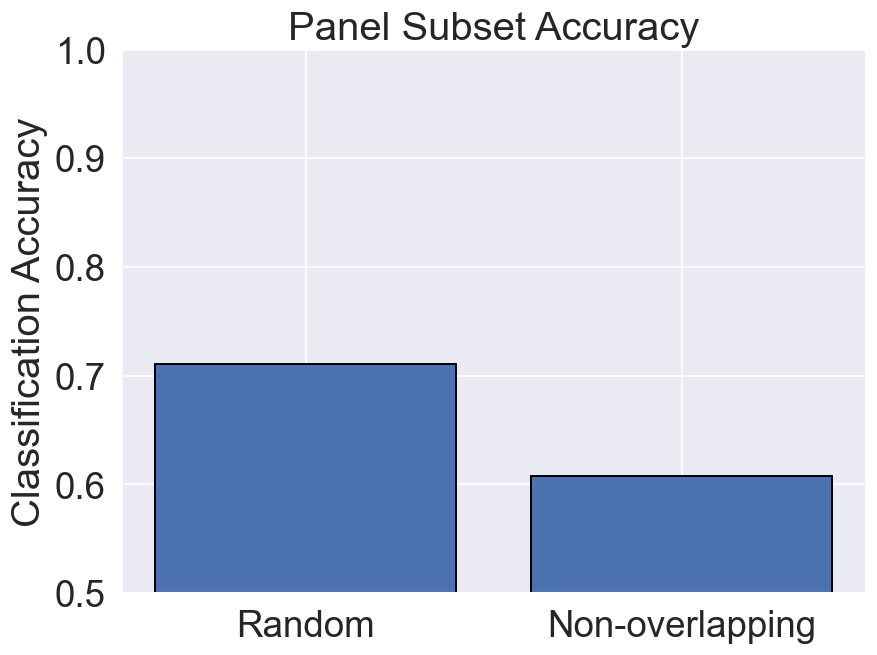

In [147]:
# Plot error bar comparison of each 500 gene panel
# Plot accuracy of non-overlapping genes
accuracyBaseline = evalPanel(gluData,list(rSet),gluData.obs["cluster_label"],False);
accuracyOverlap = evalPanel(gluData,list(rSet - prSet - svSet),gluData.obs["cluster_label"],False);

# Make plots
# fig, ax = plt.subplots()
plt.figure(figsize=(8, 6), dpi=120)
# ax.bar(["Wilcoxon","PROPOSE","scGeneFit","activeSVM","MERSCOPE"],[wilAccuracy[4],prAccuracy,gfAccuracy,svAccuracy,mrAccuracy],
#       edgecolor = 'black',linewidth = 2)
plt.bar(['Random','Non-overlapping'],[accuracyBaseline,accuracyOverlap],
       edgecolor = 'black', linewidth = 1.2)
plt.ylim(0.5, 1)
plt.ylabel("Classification Accuracy")
plt.title("Panel Subset Accuracy")

## Distributions of gene metrics

<AxesSubplot:xlabel='pts_diff', ylabel='Count'>

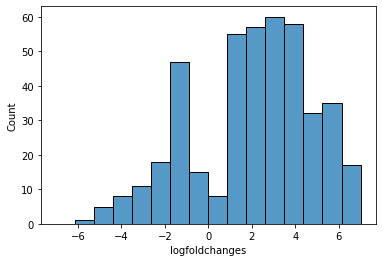

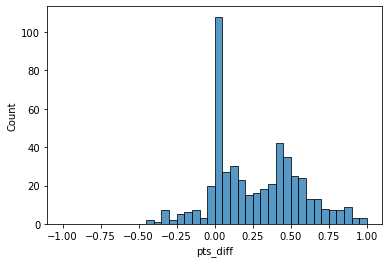

In [24]:
# Distribution of logfoldchanges and percentage differences for one subclass grou
sns.histplot(genesFiltered["logfoldchanges"],binrange=[-7, 7], bins = 'auto')
plt.figure()
sns.histplot(genesFiltered["pts_diff"],binrange=[-1, 1], bins = 40)

## Random gene panel selection
Examine the efficacy of randomly selected genes for panel

In [11]:
# Grab the top 1000 differentially expressed genes in each cluster

for indx in gluData.uns["rank_genes_groups"]["pts"].columns:
    genesRanked = pd.DataFrame(
            {key: gluData.uns["rank_genes_groups"][key][indx]
            for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
    pts = gluData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
    pts_rest = gluData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
    pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
    genesRanked = pd.concat([genesRanked, pts, pts_rest, pts_diff], axis=1)
    genesRanked = genesRanked.sort_values(by=["scores"], ascending=False, key=abs)
    genesFiltered = genesRanked.iloc[0:1000,:]
    markerGenes[indx] = genesFiltered["names"][0:1000].tolist()
    
topGenes = getUniqueGenes(markerGenes,1000)

In [12]:
# Randomly sample from top 1000 DE genes
import random
import re

print("Randomly selecting from top %i DE genes" %len(topGenes))

np.random.seed(0)
rSample = np.zeros(10)
for i in range(len(rSample)):
    rGeneList = random.sample(sorted(topGenes),500)
    rSample[i] = evalPanel(gluData,rGeneList,gluData.obs["cluster_label"],False)
rAccuracy = np.mean(rSample)
rPanel = {'500' : rGeneList} # Just take last randomly sampled list as panel for confusion matrix assessment
print(rAccuracy)

# Randomly sample from top 1000 DE genes
# rGeneList = random.sample(sorted(topGenes),32*202)

# Assess accuracy of subsets of panel
# count = 0
# rAccuracy = np.zeros(5)
# for i in [202, 404, 500, 1120, 32*202]:
#     rAccuracy[count] = evalPanel(gluData,rGeneList[0:i],gluData.obs["cluster_label"],False)
#     count = count + 1

Randomly selecting from top 7397 DE genes
0.7247850278199292


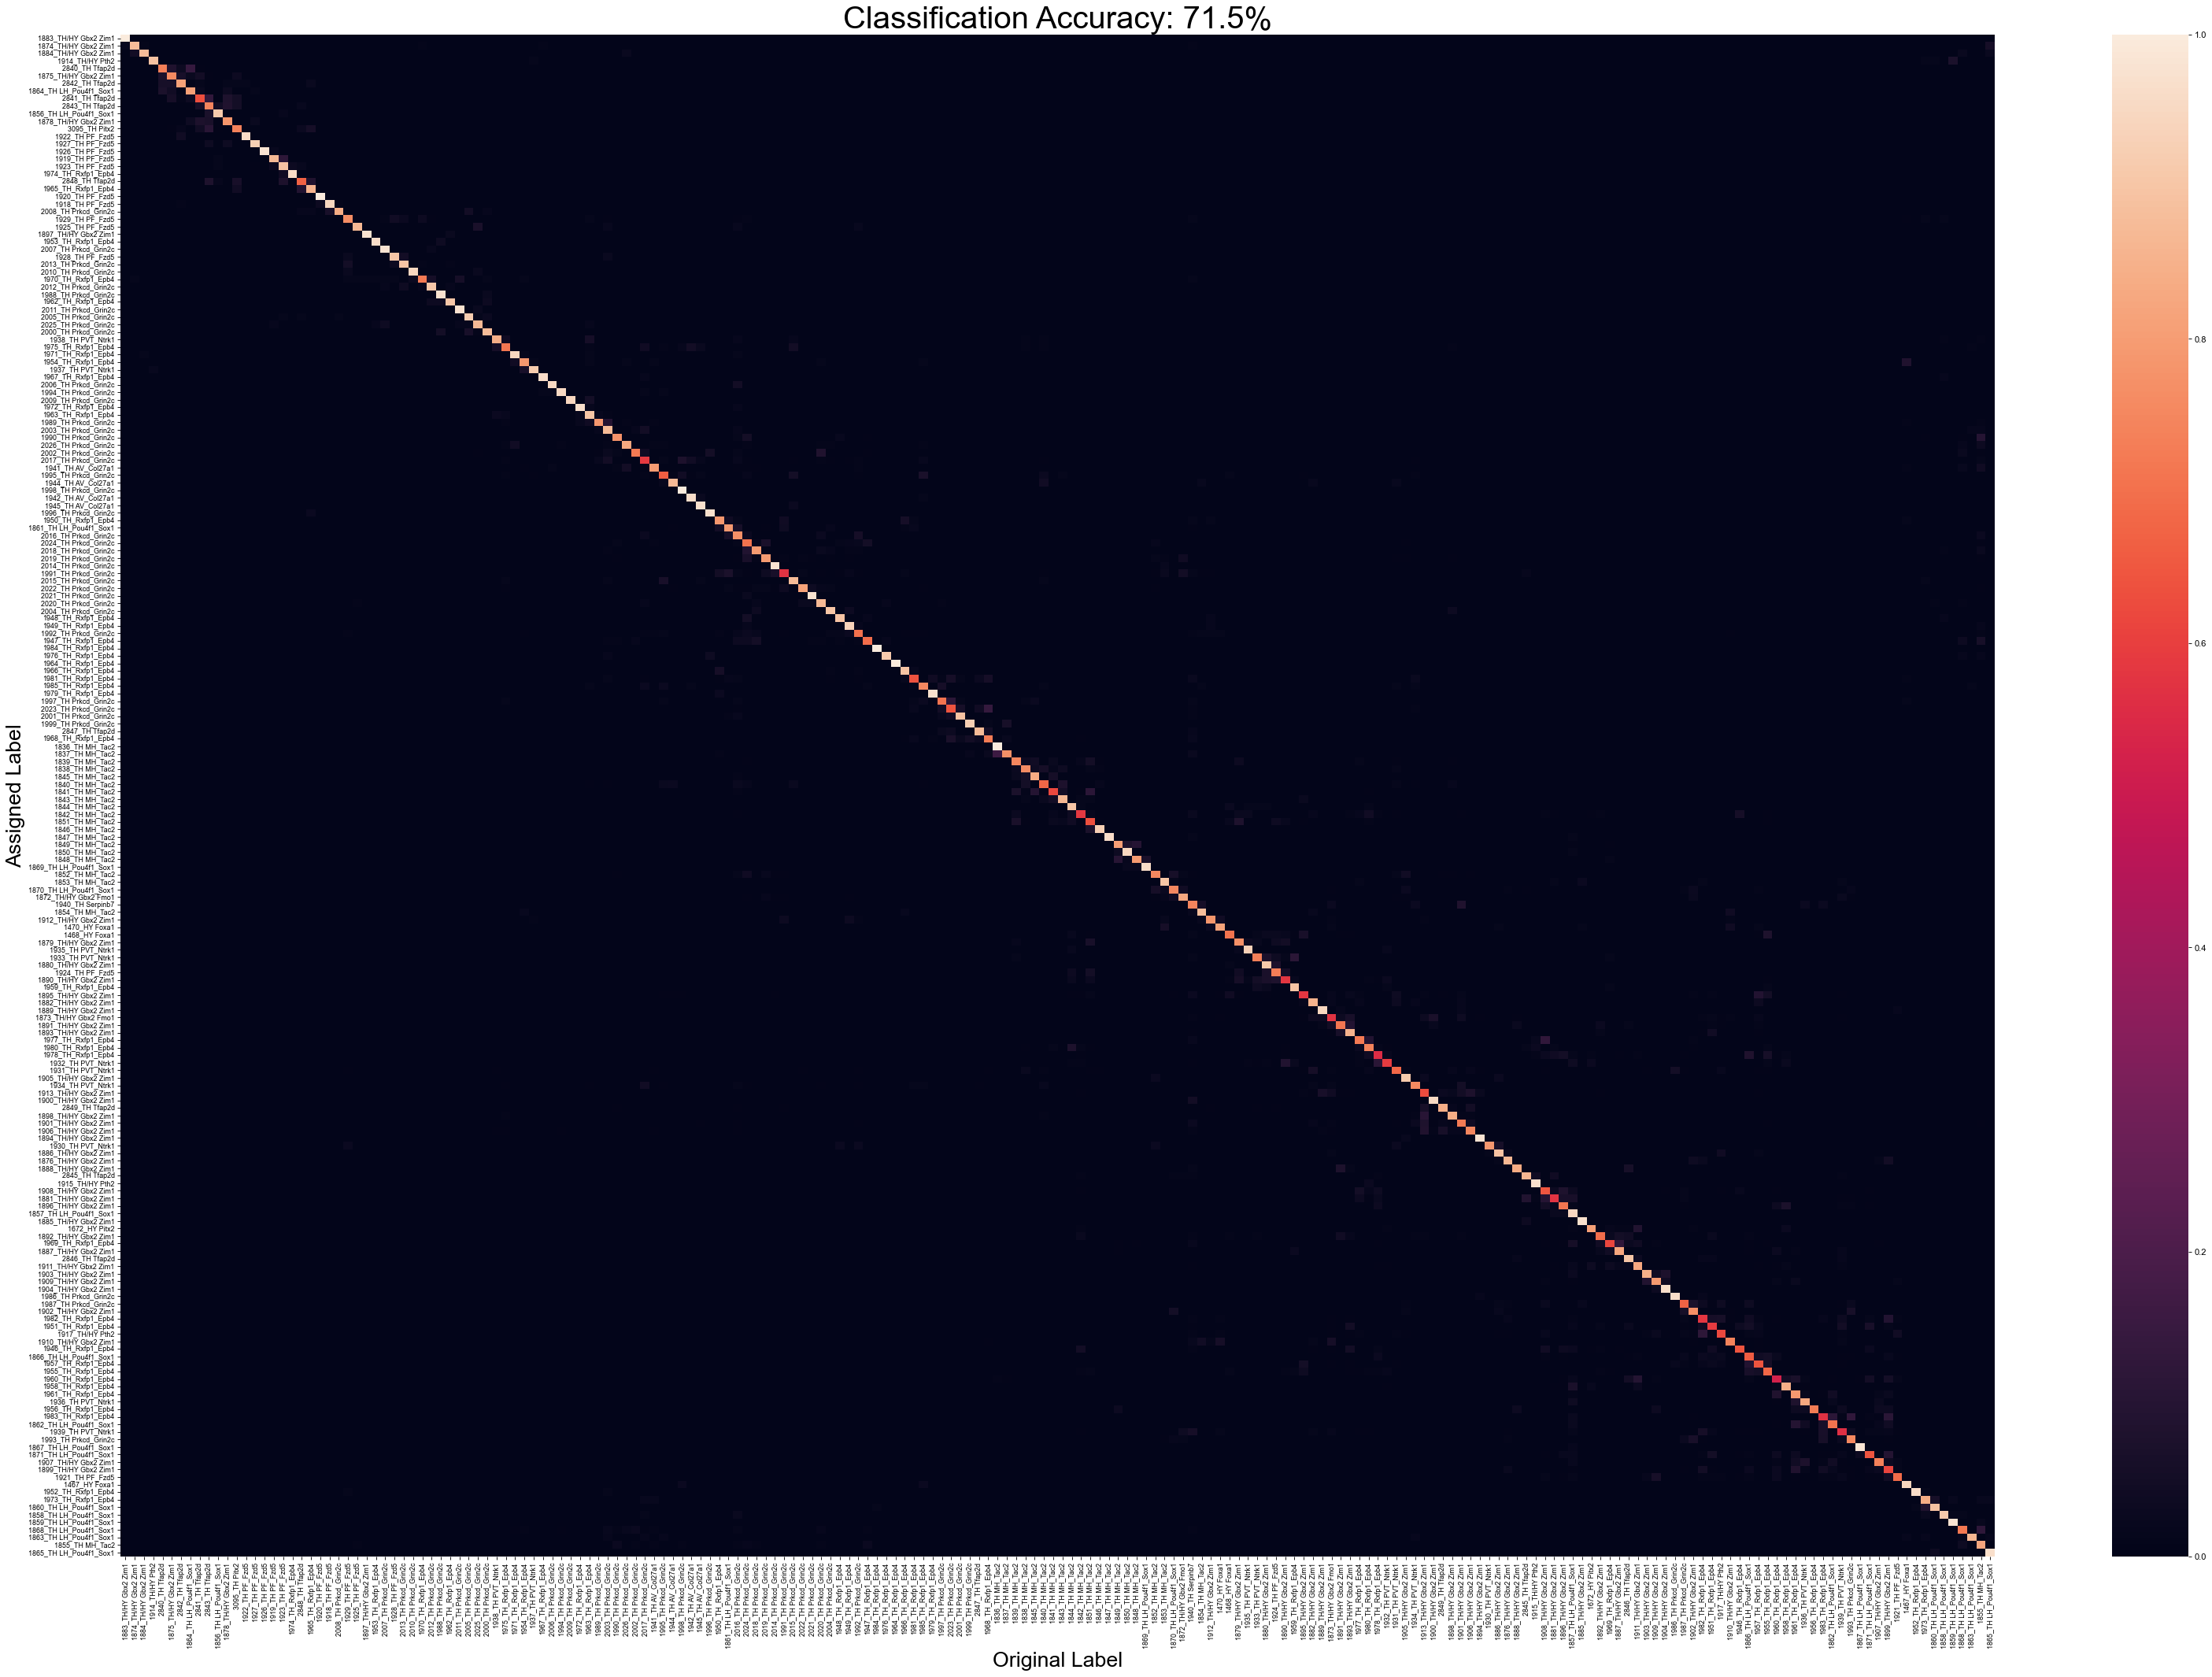

In [13]:
rPanel = {'500' : rGeneList}
[_,_,rMatrix] = evalPanel(gluData,rPanel['500'],gluData.obs["cluster_label"],True)

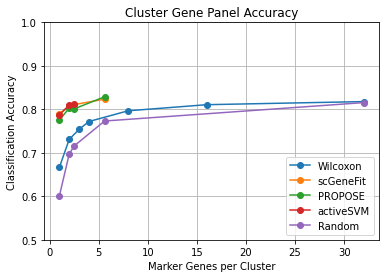

In [366]:
# Plot relative accuracy of each method
fig, ax = plt.subplots()
ax.plot(panelIDs,wilAccuracy,'o-',label="Wilcoxon")
ax.plot([1, 2, 2.5, 5.6],gfAccuracy,'o-', label="scGeneFit")
ax.plot([1, 2, 2.5, 5.6],prAccuracy,'o-', label="PROPOSE")
ax.plot([1, 2, 2.5],svAccuracy,'o-', label="activeSVM")
ax.plot([1, 2, 2.5, 5.6, 32],rAccuracy,'o-',label="Random")
ax.set_ylim(.5, 1)
plt.grid()
plt.xlabel("Marker Genes per Cluster")
plt.ylabel("Classification Accuracy")
plt.title("Cluster Gene Panel Accuracy")
plt.legend()

## Compare randomly selected gene panel + forebrain panel

In [14]:
with open("../Data/Gene Panels/MERSCOPE_cluster_genes.json", "r") as f:
    fbPanel = json.load(f)
    
fbAccuracy = [evalPanel(gluData,fbPanel['500'],gluData.obs["cluster_label"],False)]

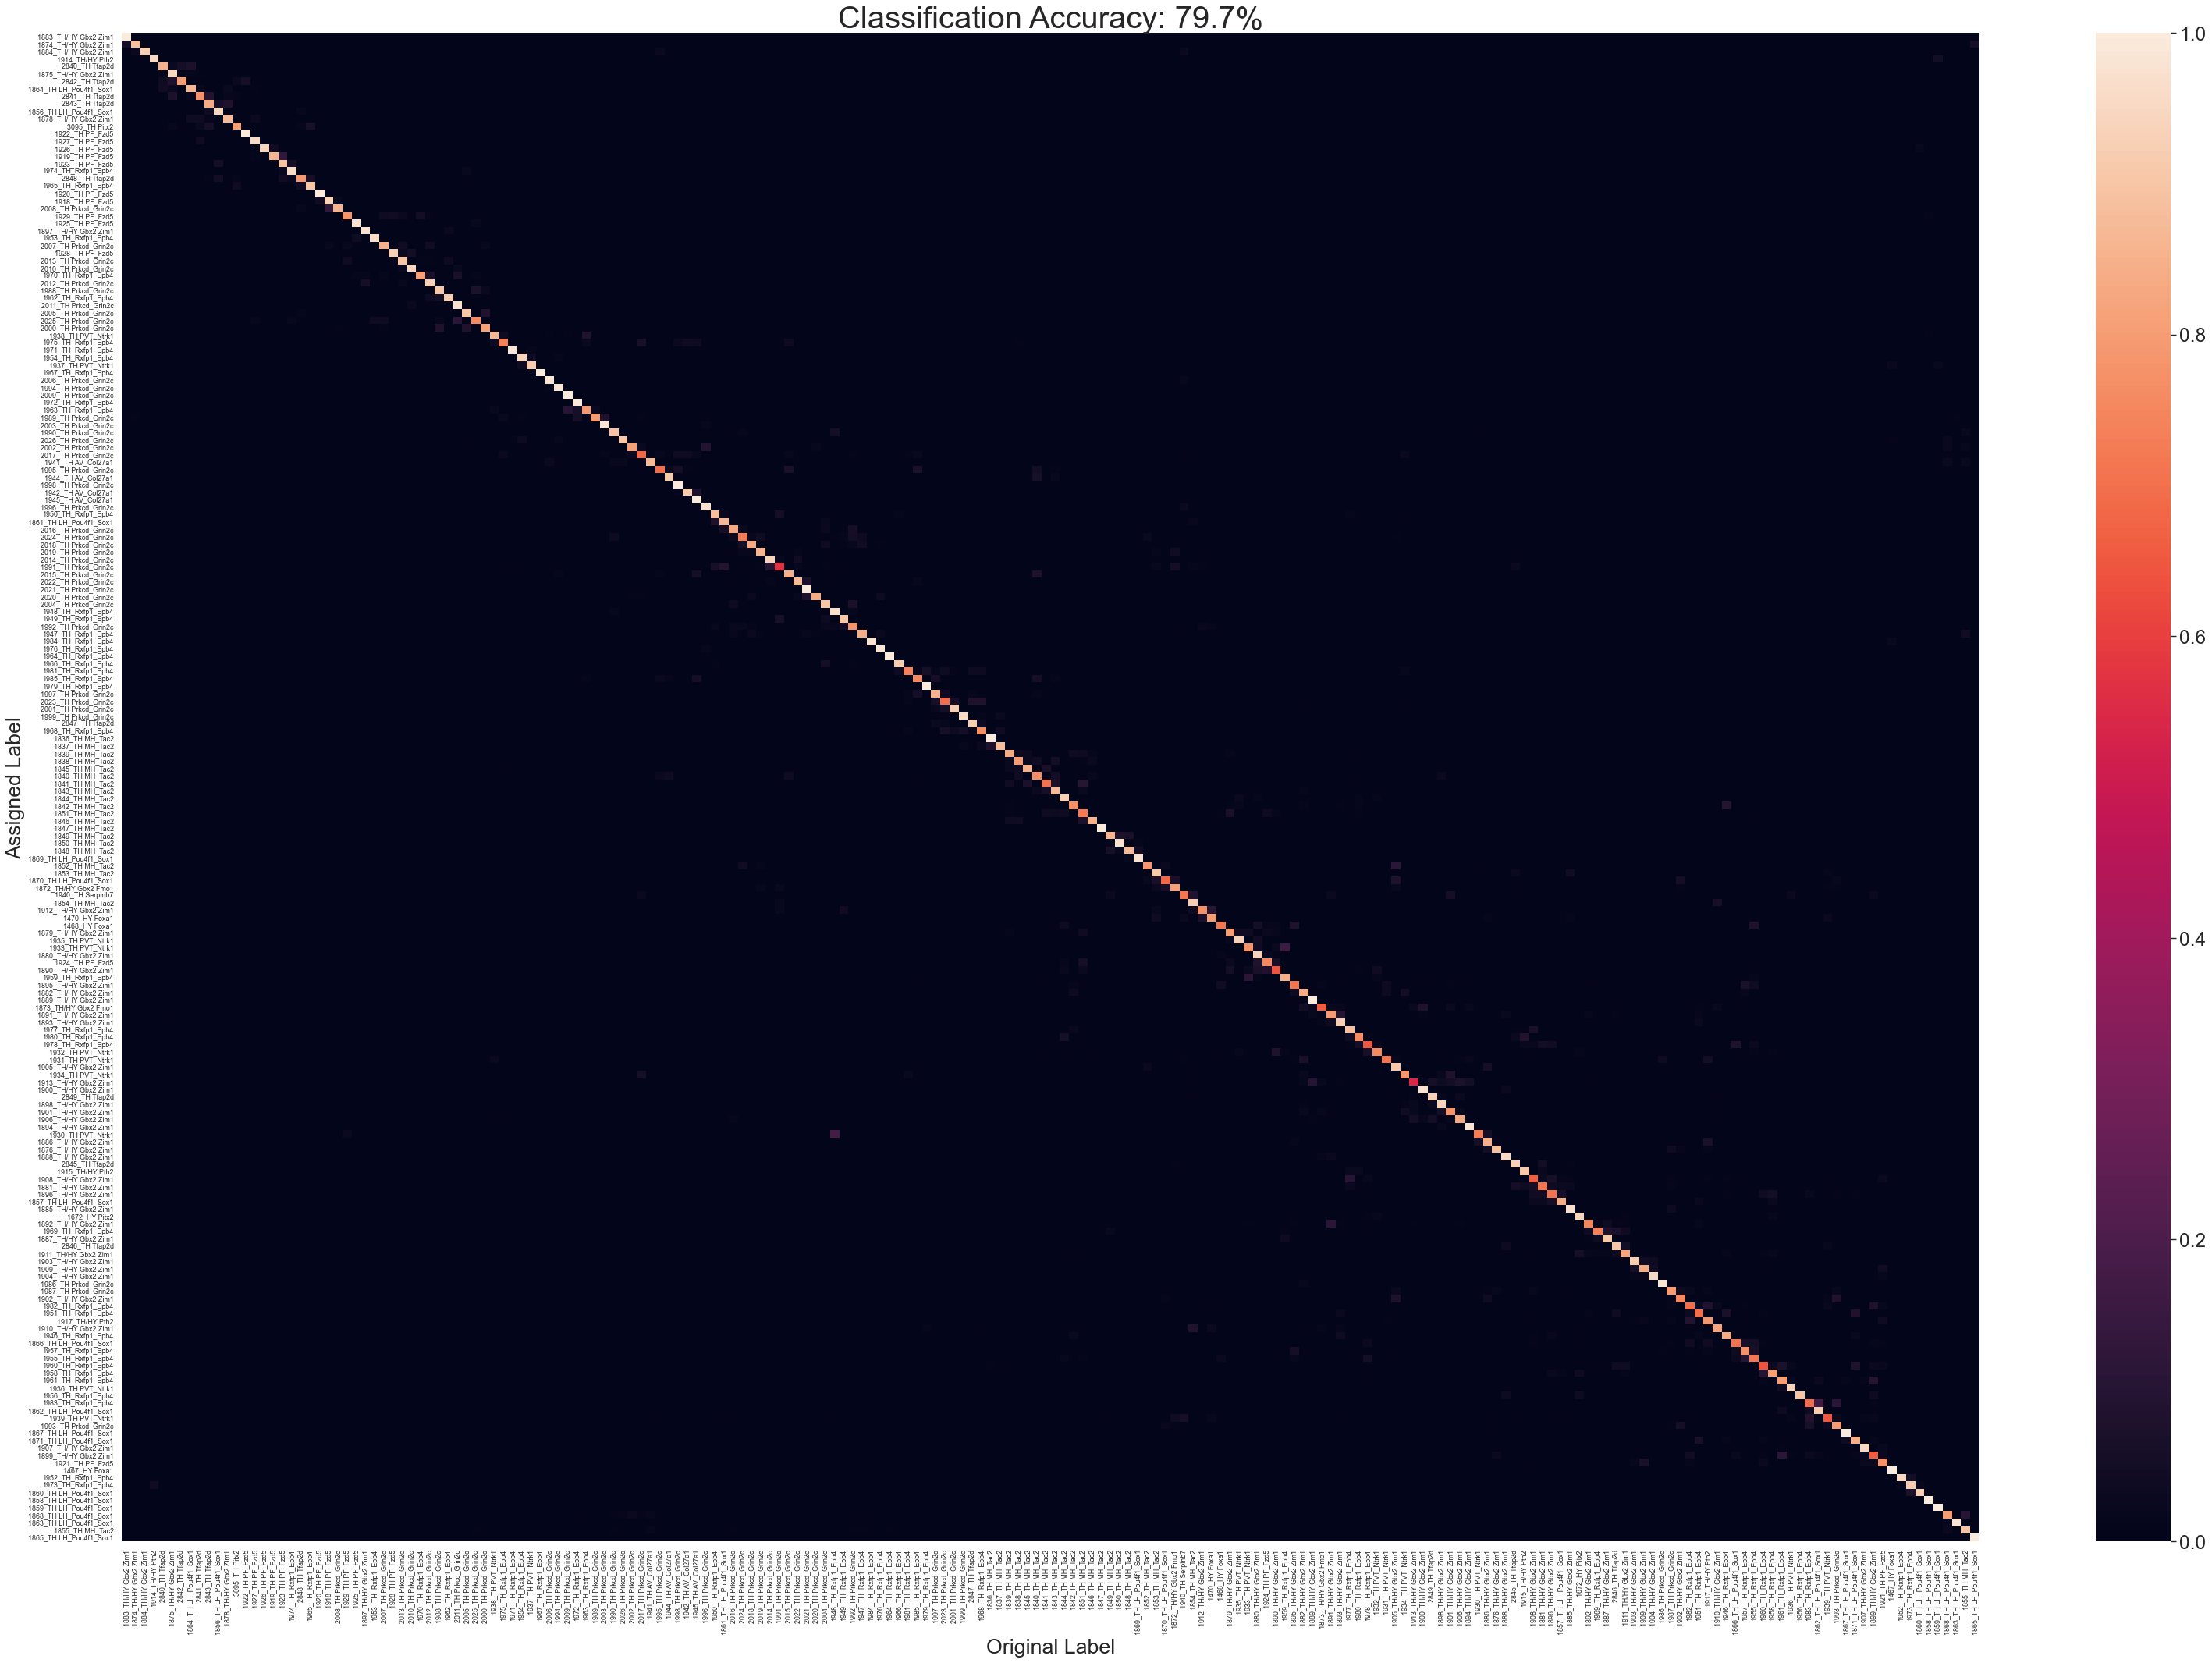

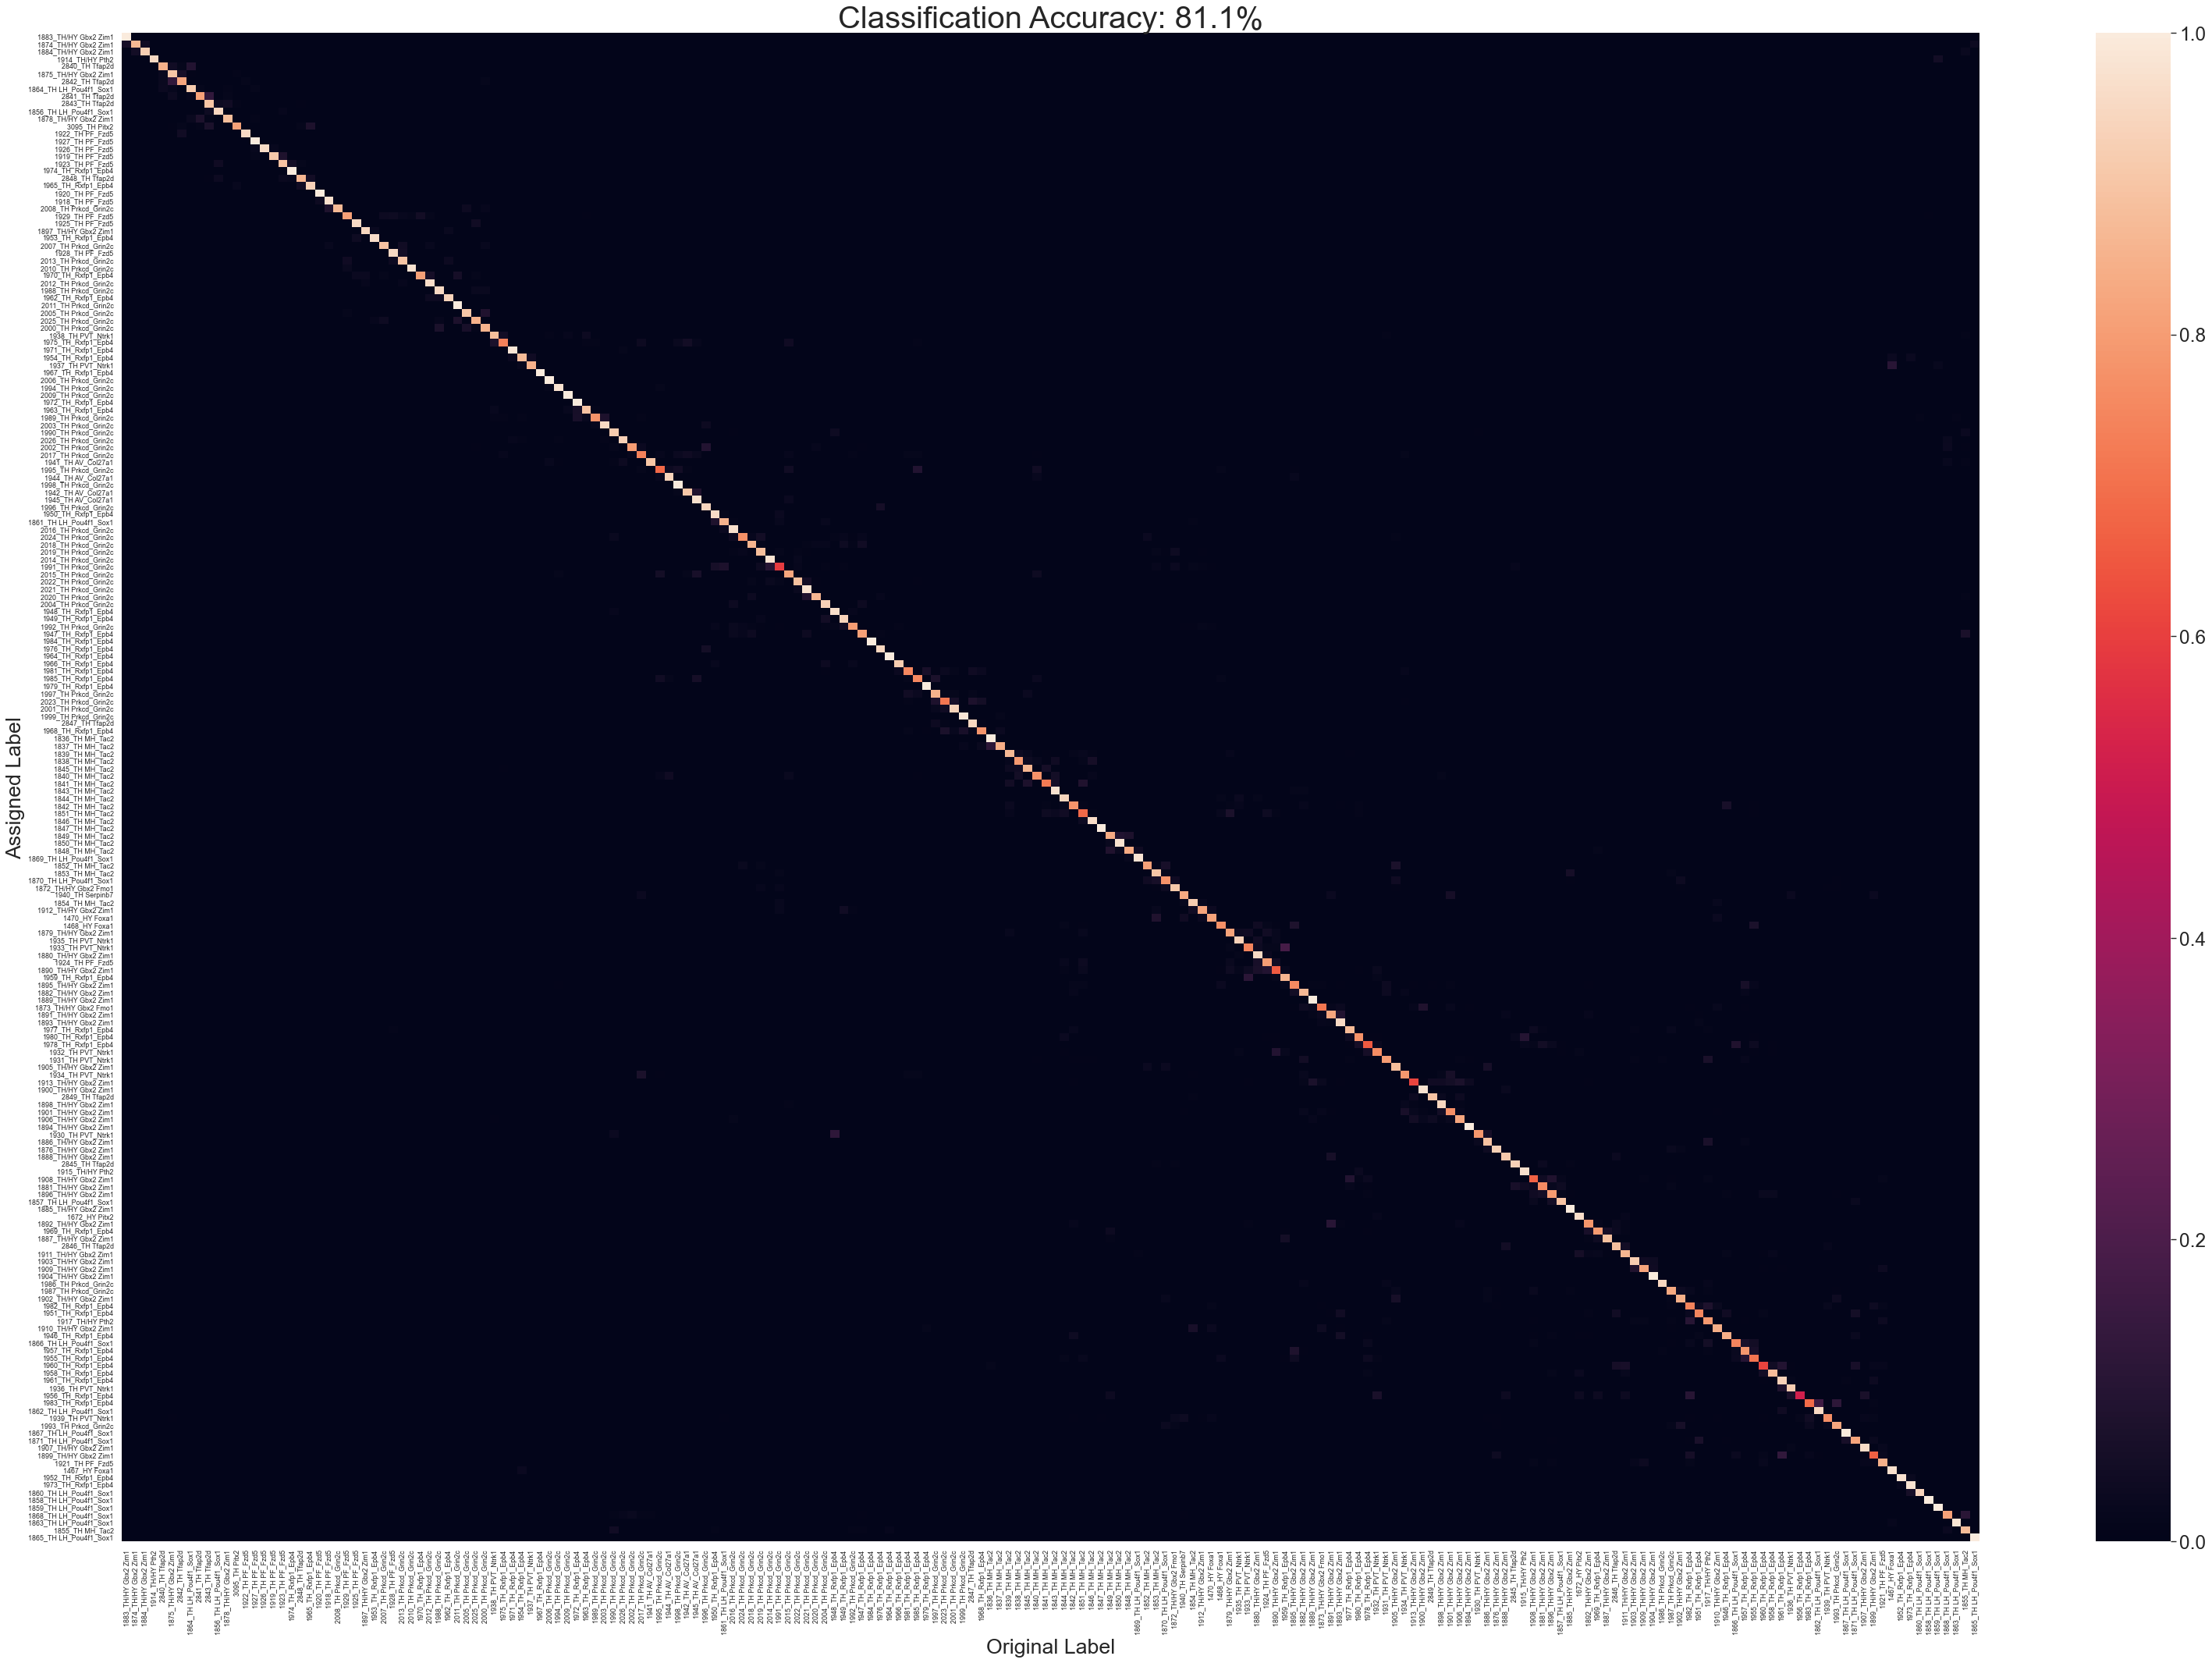

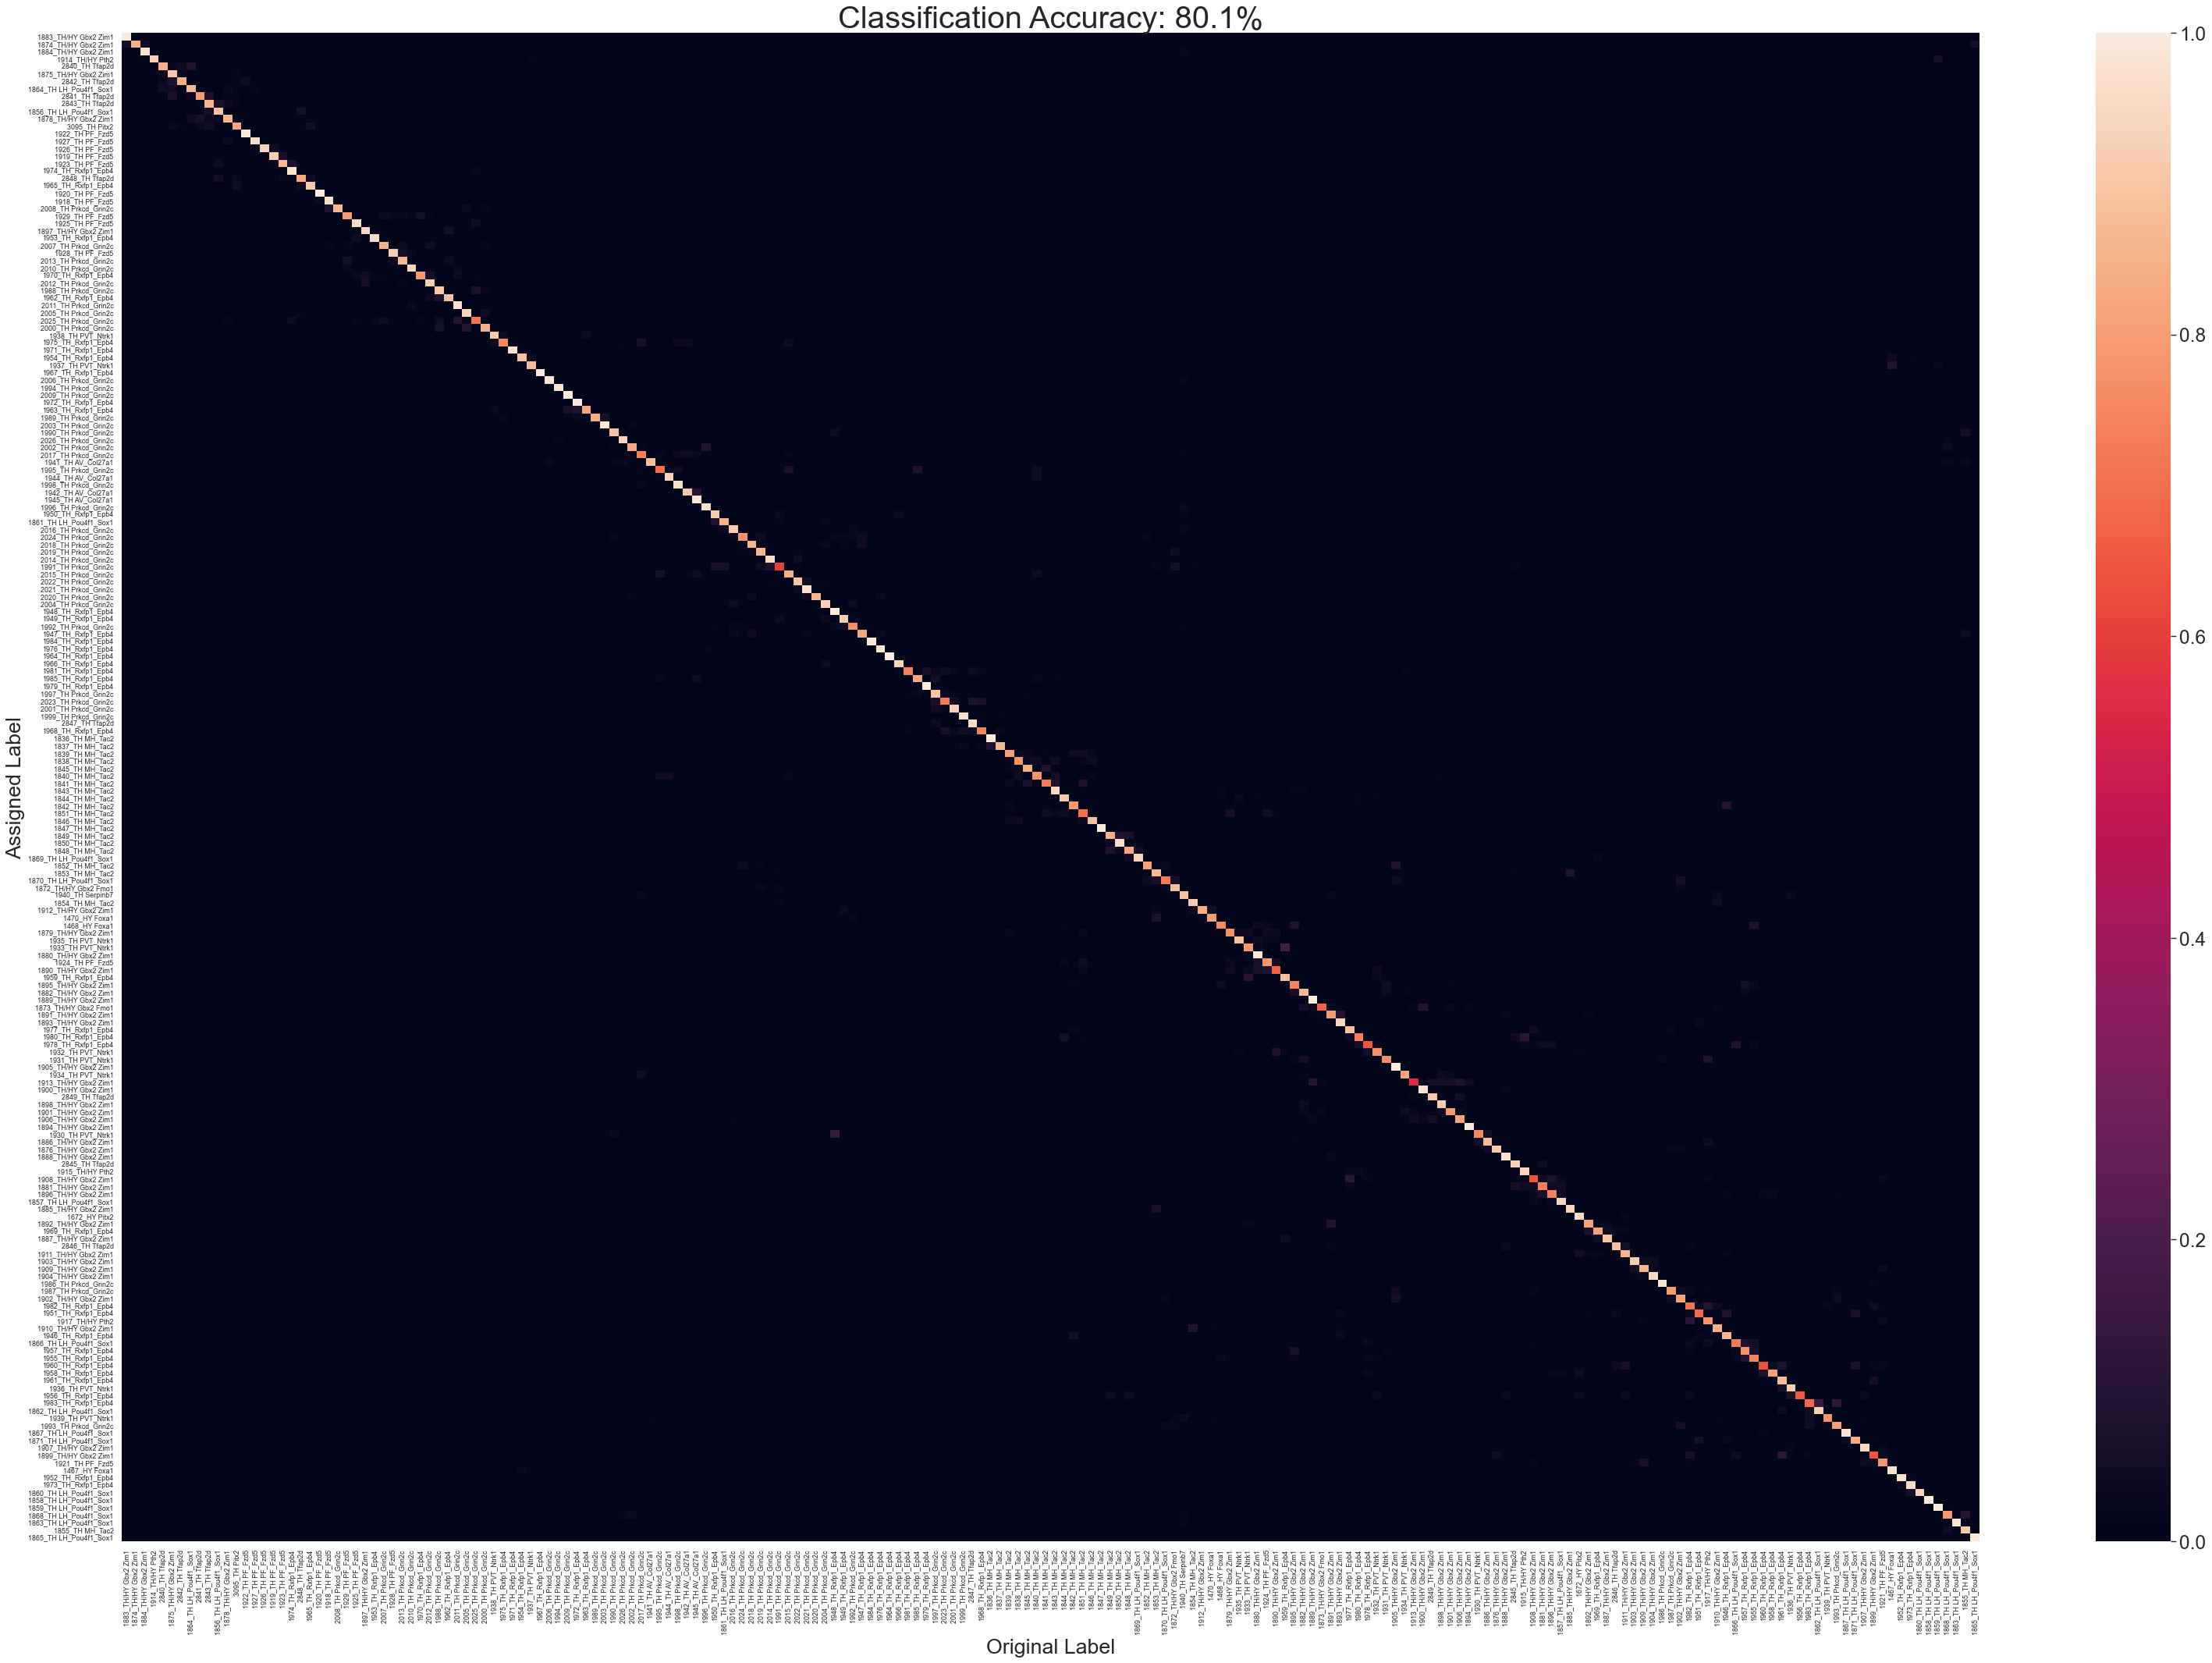

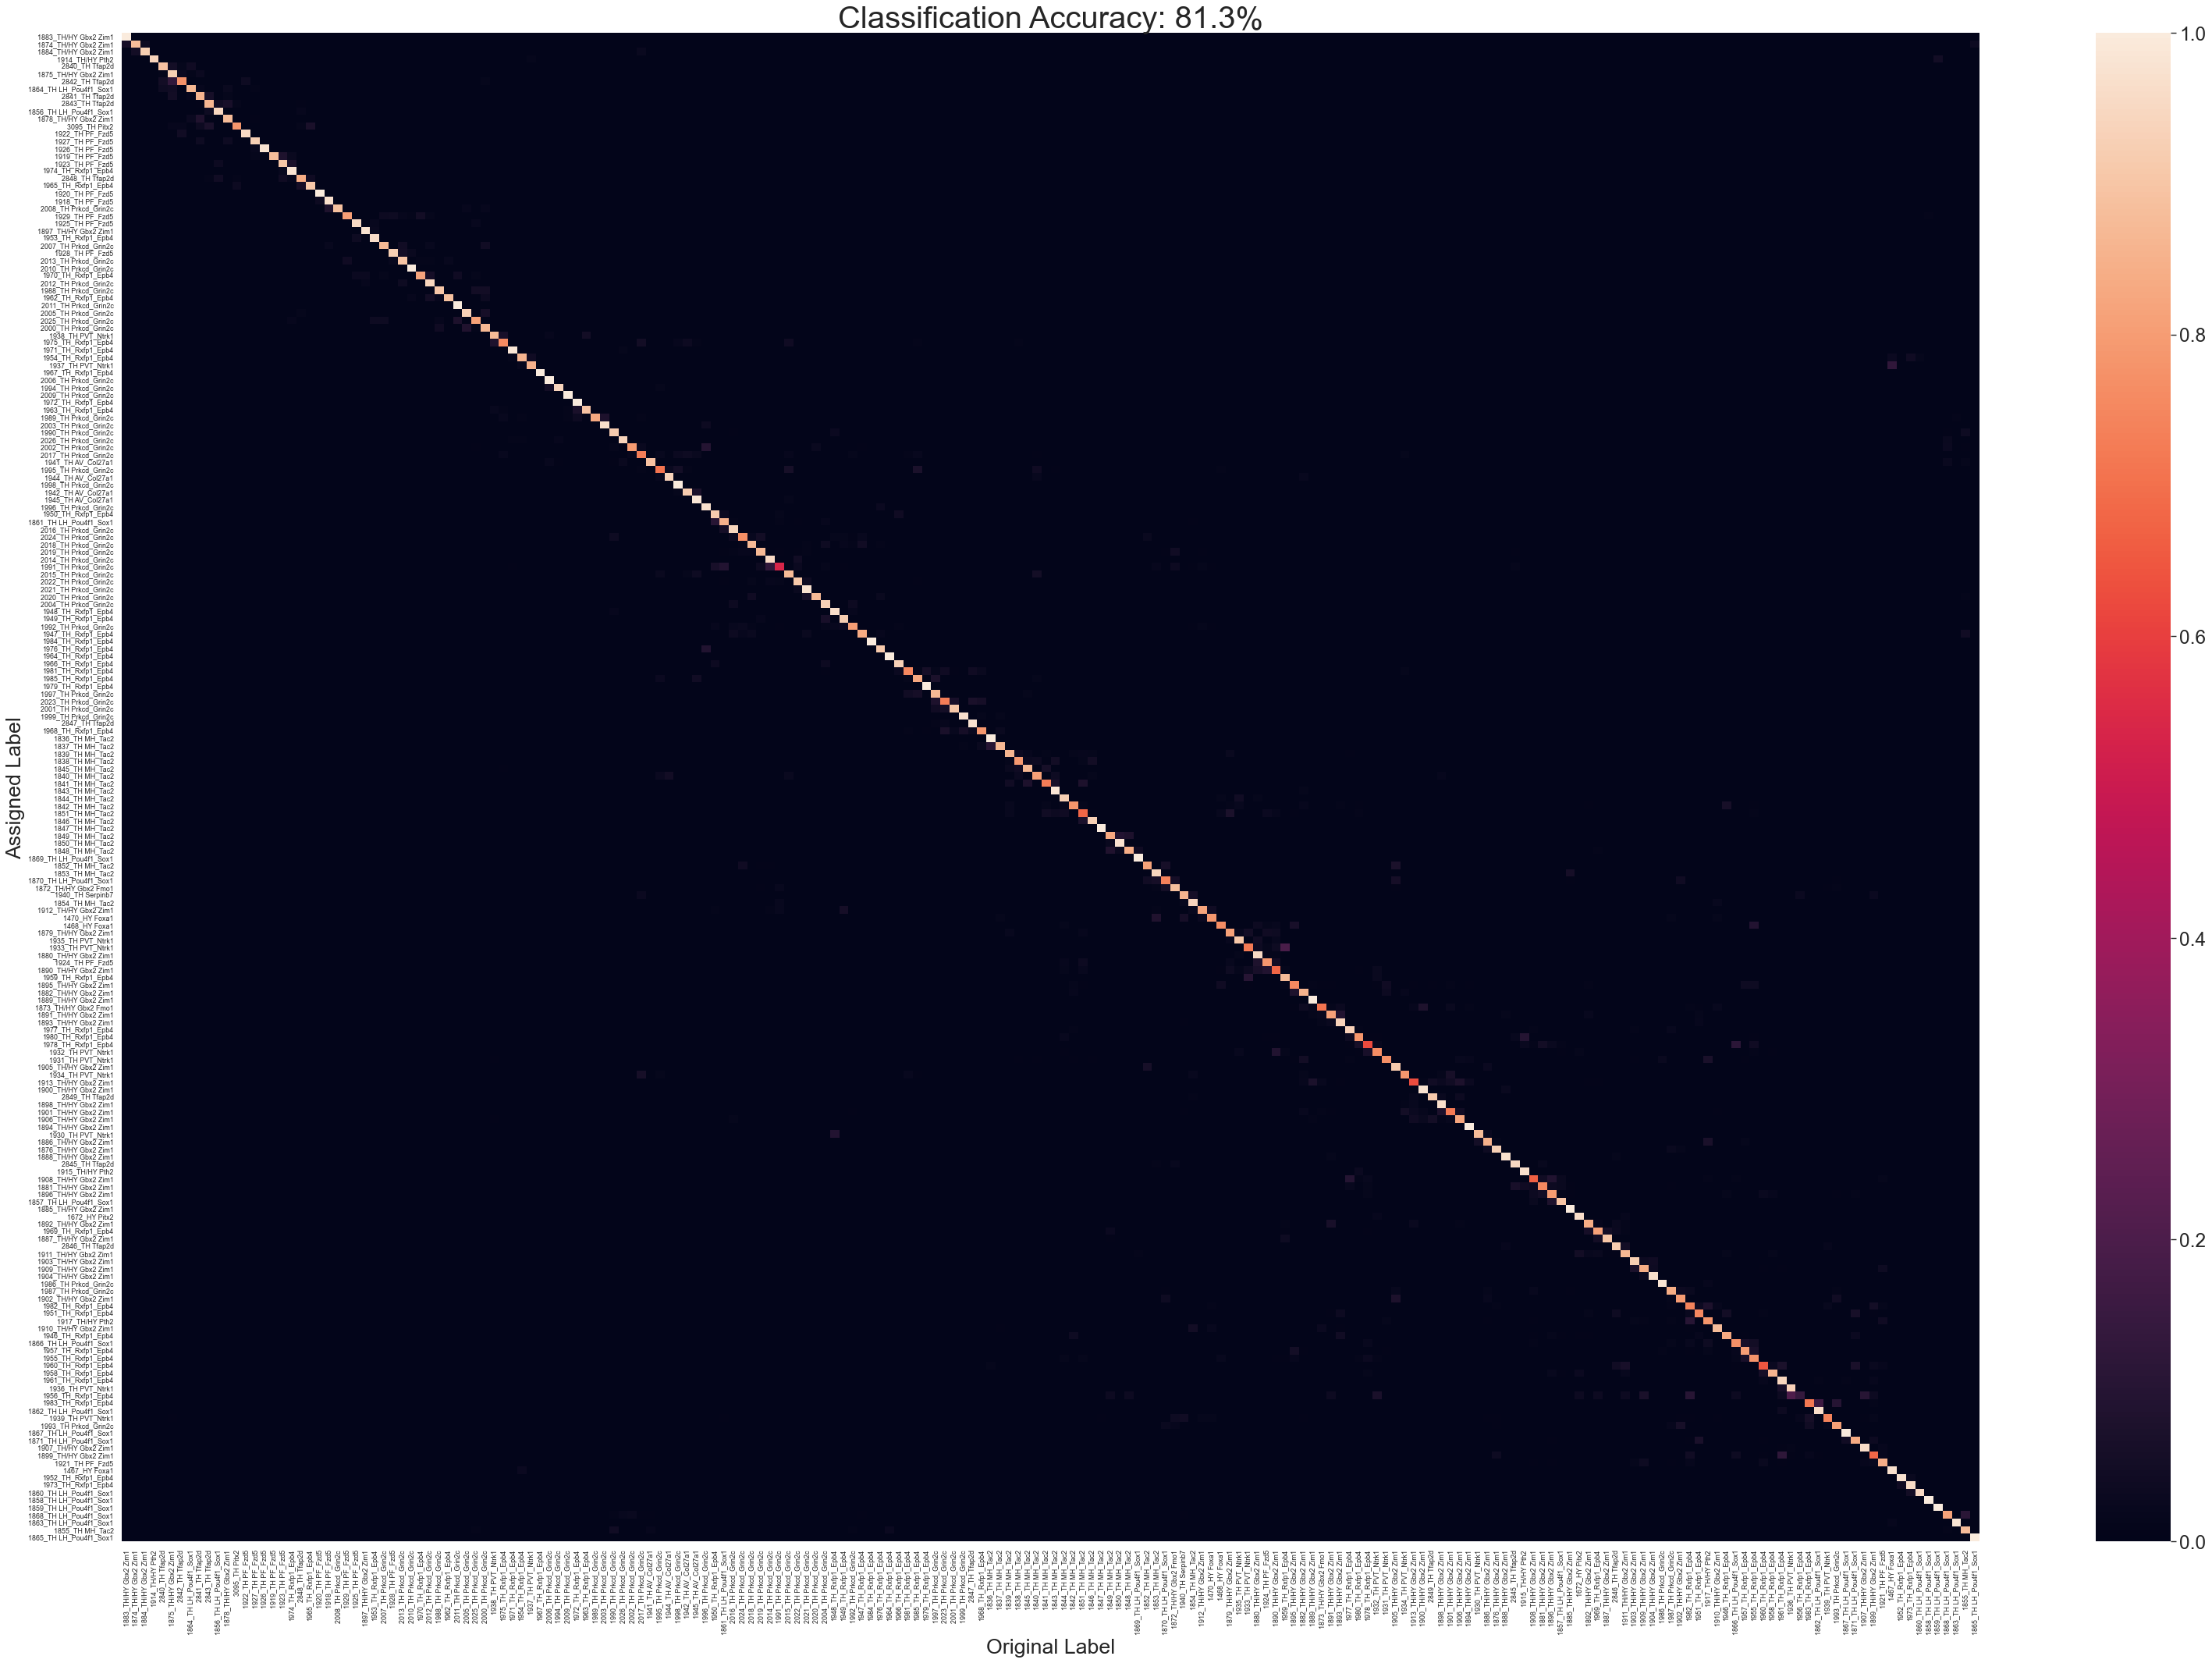

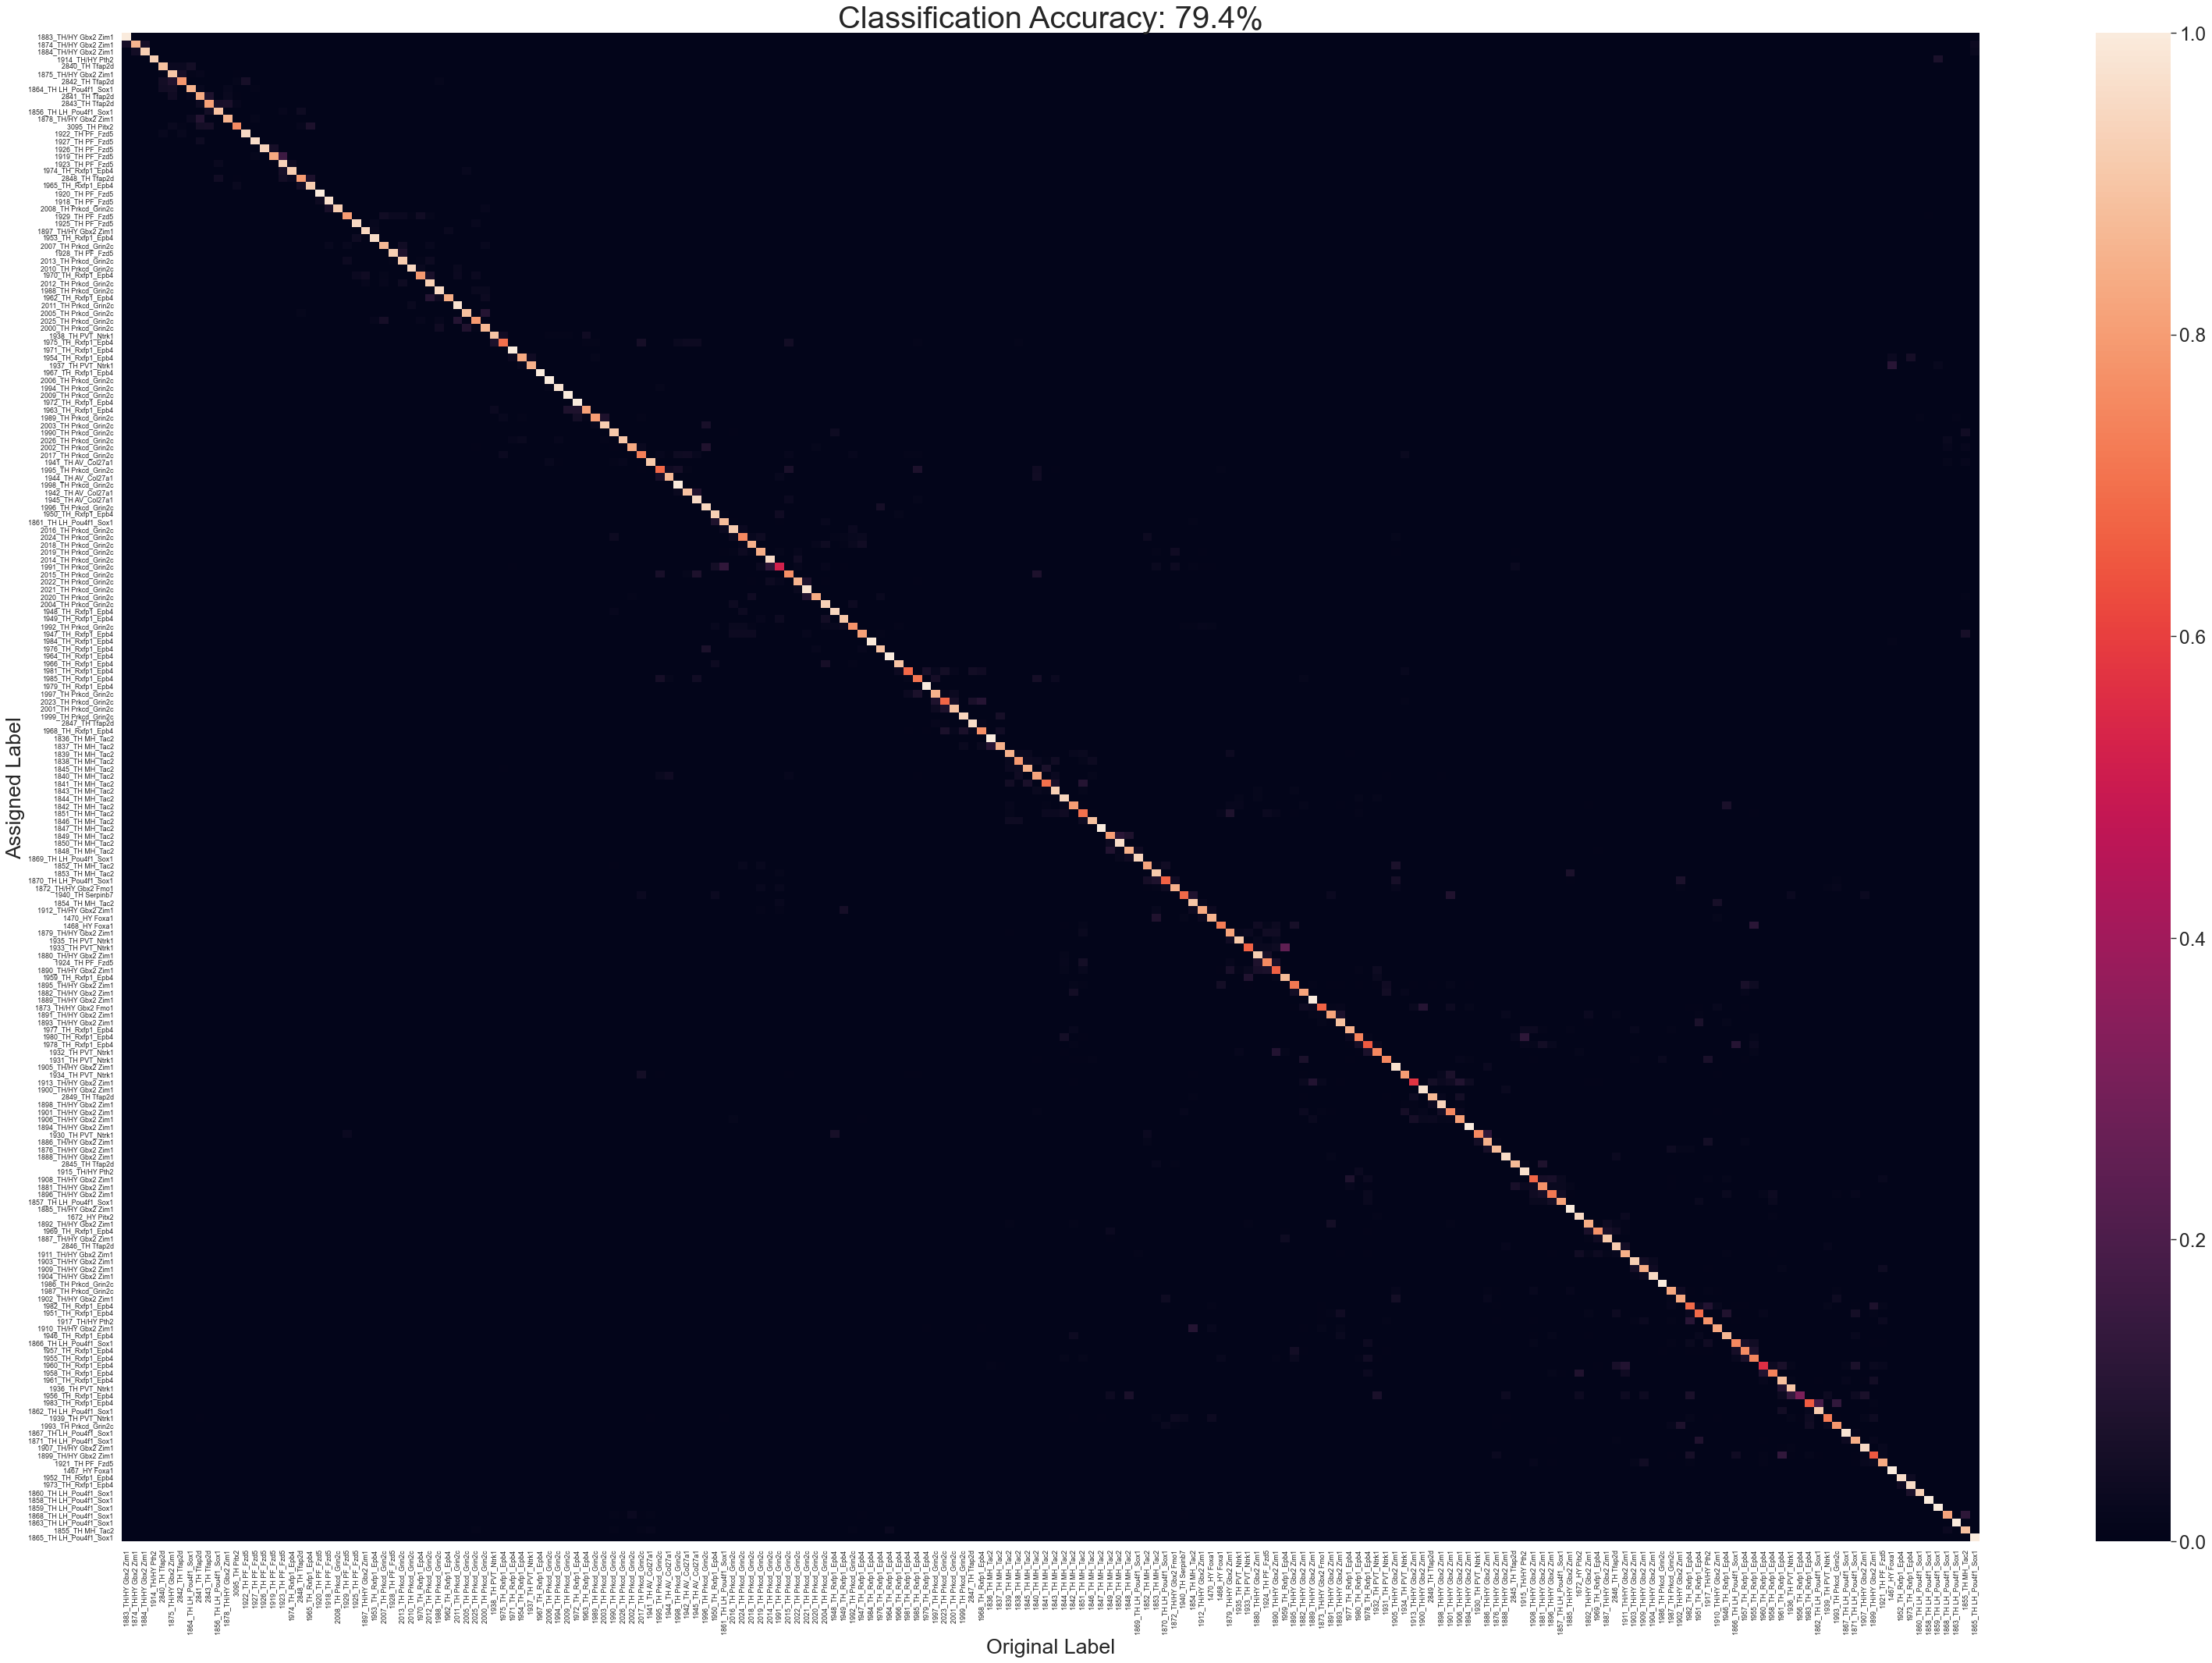

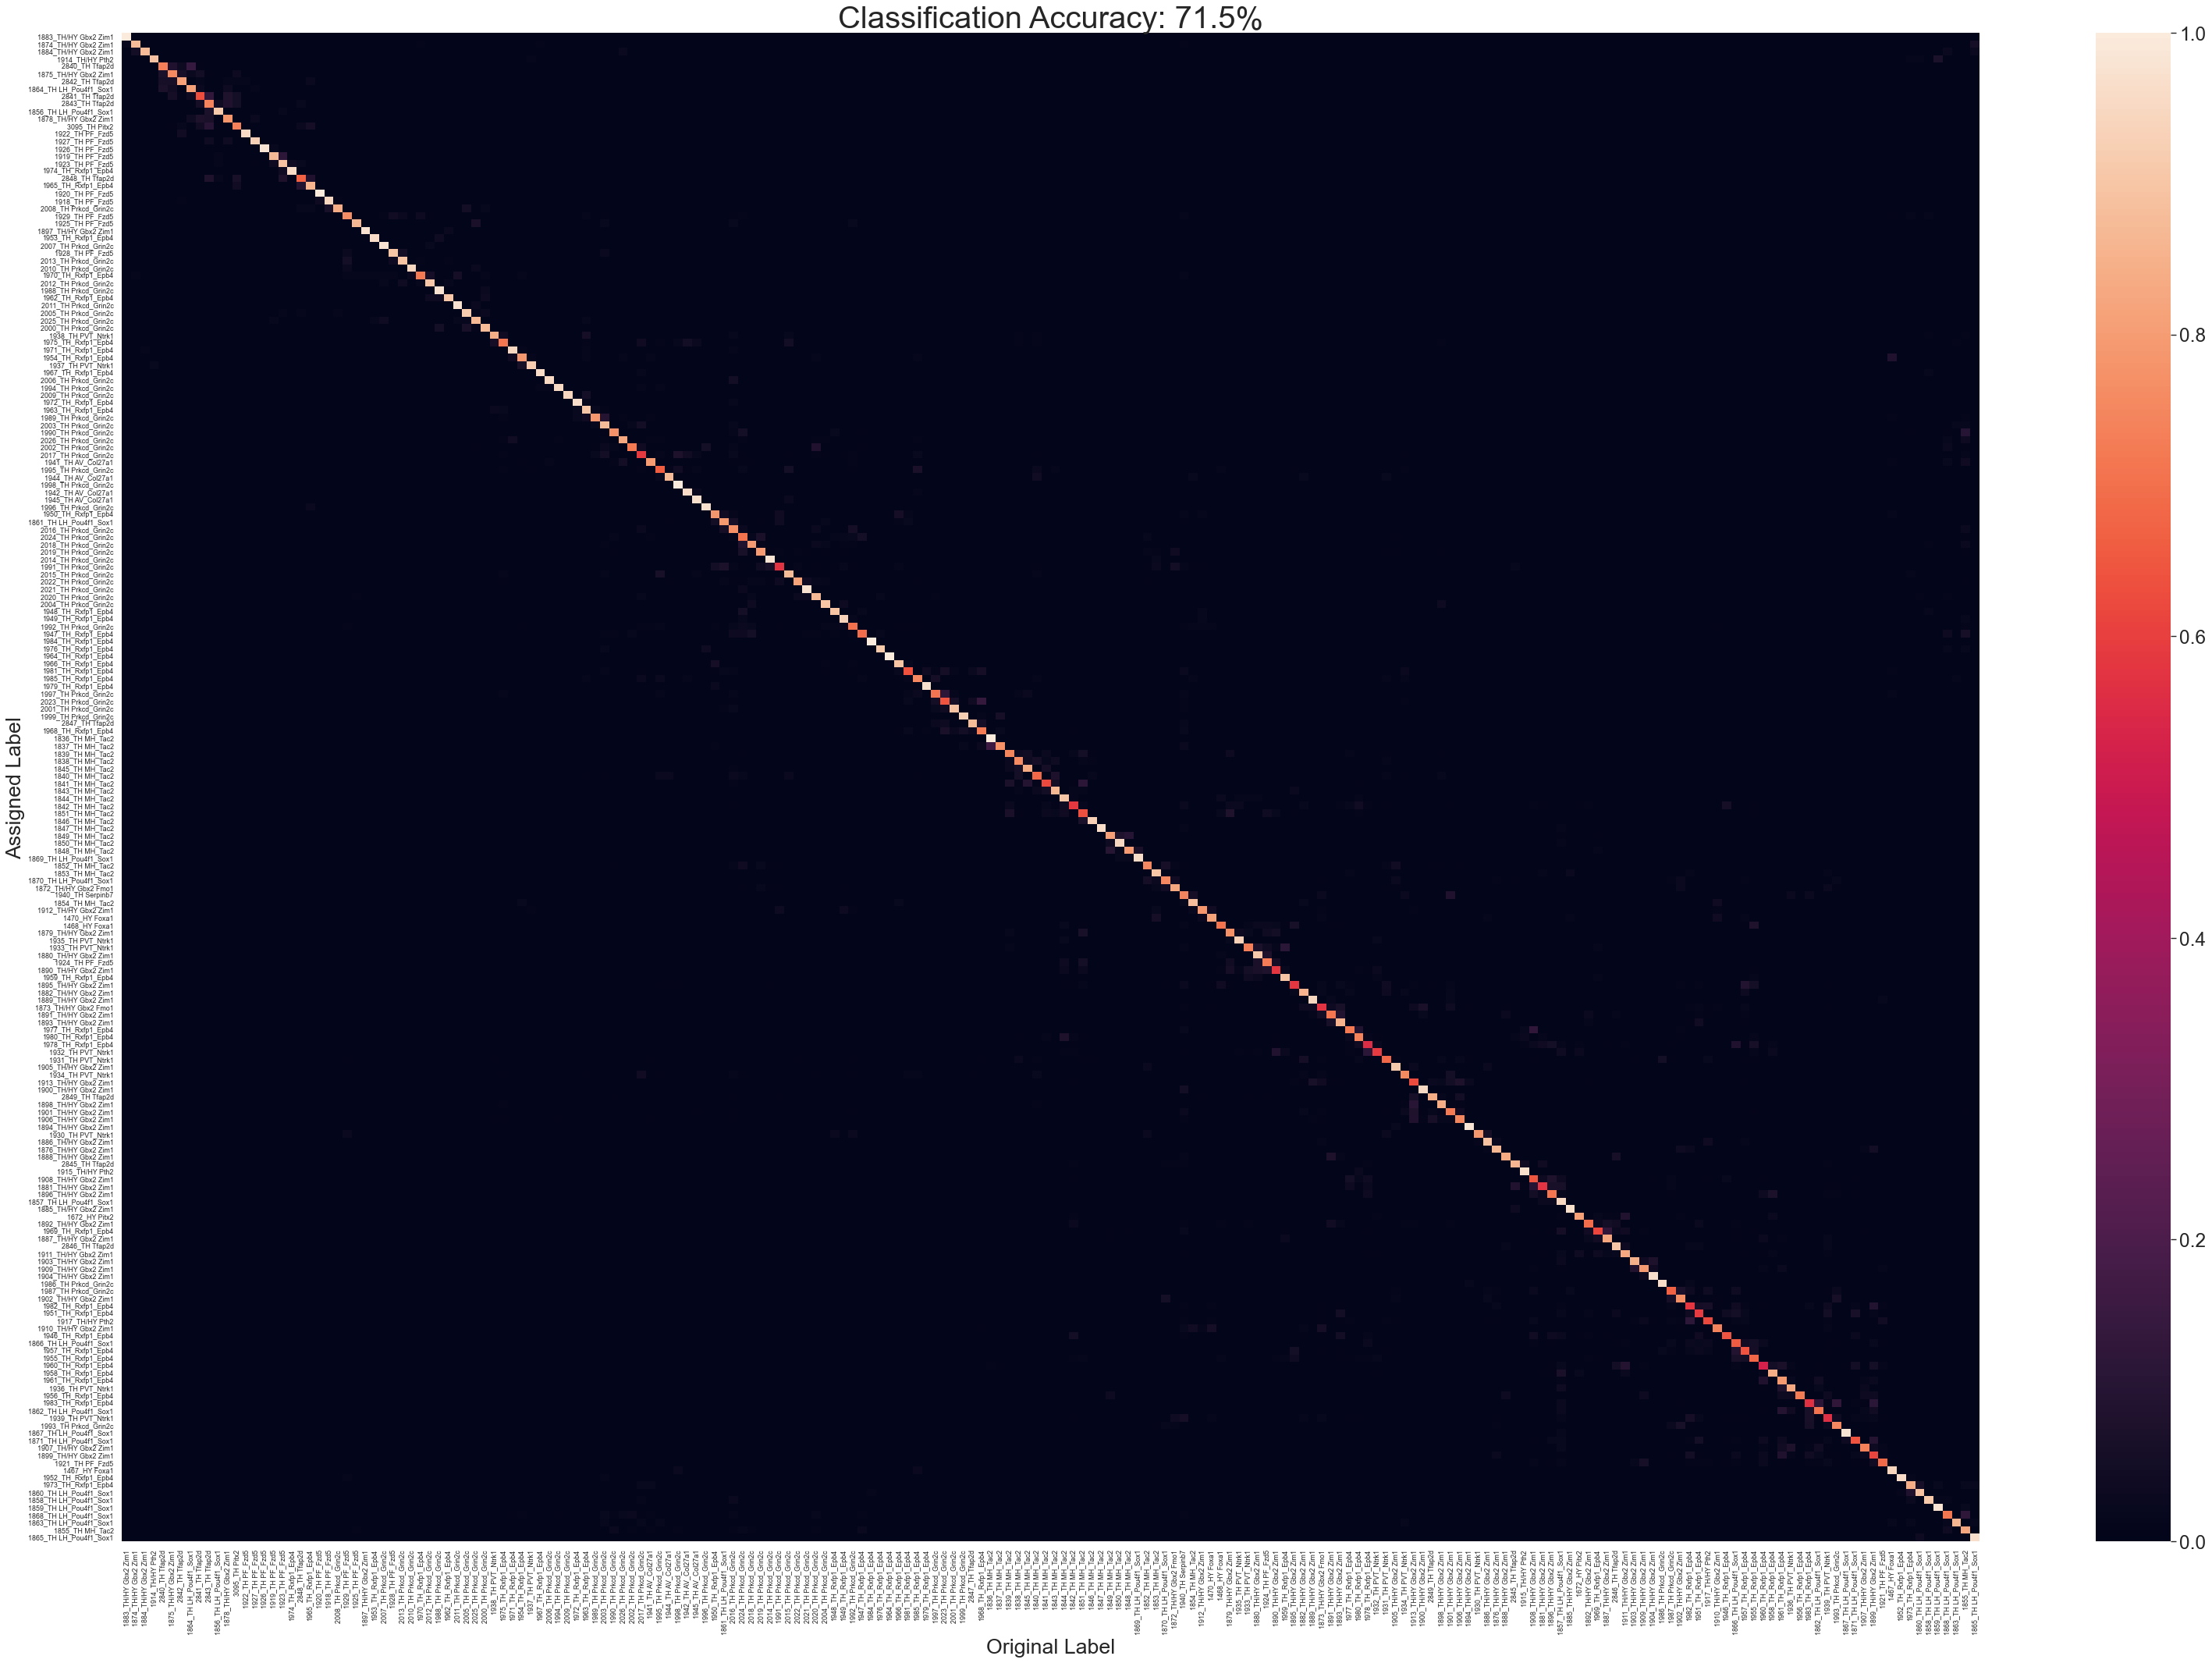

In [15]:
# Systematically evaluate gene panels
[_,_,wlMatrix] = evalPanel(gluData,wlPanel['448'],gluData.obs["cluster_label"],True)
[_,_,gfMatrix] = evalPanel(gluData,gfPanel['500'],gluData.obs["cluster_label"],True)
[_,_,prMatrix] = evalPanel(gluData,prPanel['500'],gluData.obs["cluster_label"],True)
[_,_,svMatrix] = evalPanel(gluData,svPanel['500'],gluData.obs["cluster_label"],True)
[_,_,fbMatrix] = evalPanel(gluData,fbPanel['500'],gluData.obs["cluster_label"],True)
[_,_,rMatrix] = evalPanel(gluData,rPanel['500'],gluData.obs["cluster_label"],True)

Text(0.5, 1.0, '500 Gene - Panel Accuracy')

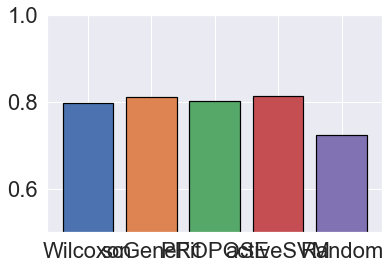

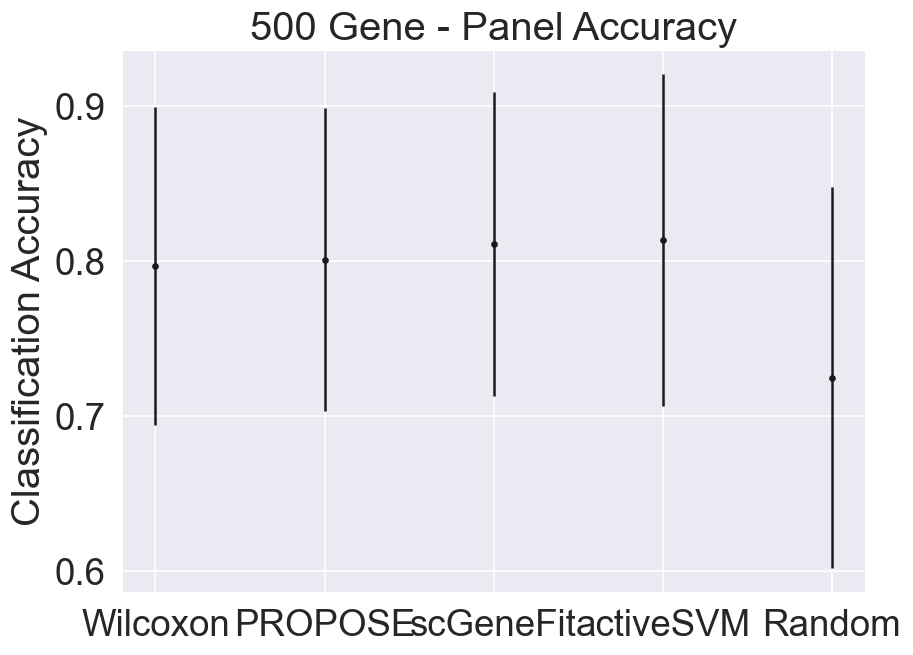

In [16]:
# Plot error bar comparison of each 500 gene panel
# Compute standard deviation
wlError = np.std(np.diag(wlMatrix))
gfError = np.std(np.diag(gfMatrix))
prError = np.std(np.diag(prMatrix))
svError = np.std(np.diag(svMatrix))
fbError = np.std(np.diag(fbMatrix))
rError = np.std(np.diag(rMatrix))

# Make plots
fig, ax = plt.subplots()
plt.figure(figsize=(8, 6), dpi=120)
# ax.bar(["Wilcoxon","PROPOSE","scGeneFit","activeSVM","MERSCOPE"],[wilAccuracy[4],prAccuracy,gfAccuracy,svAccuracy,mrAccuracy],
#       edgecolor = 'black',linewidth = 2)
ax.bar('Wilcoxon',wlAccuracy[4], edgecolor = 'black', linewidth = 1.2)
ax.bar('scGeneFit',gfAccuracy[2], edgecolor = 'black', linewidth = 1.2)
ax.bar('PROPOSE',prAccuracy[2], edgecolor = 'black', linewidth = 1.2)
ax.bar('activeSVM',svAccuracy[2], edgecolor = 'black', linewidth = 1.2)
# ax.bar('Forebrain',fbAccuracy,  edgecolor = 'black', linewidth = 1.2)
ax.bar('Random',rAccuracy,  edgecolor = 'black', linewidth = 1.2)
# plt.errorbar(['Wilcoxon','PROPOSE','scGeneFit','activeSVM','Forebrain'],
#              [wlAccuracy[4], prAccuracy[2], gfAccuracy[2], svAccuracy[2], fbAccuracy[0]],
#              yerr = [wlError, prError,gfError,svError,fbError], fmt = '.k')
plt.errorbar(['Wilcoxon','PROPOSE','scGeneFit','activeSVM','Random'],
             [wlAccuracy[4], prAccuracy[2], gfAccuracy[2], svAccuracy[2], rAccuracy],
             yerr = [wlError, prError,gfError,svError,rError], fmt = '.k')
ax.set_ylim(0.5, 1)
plt.ylabel("Classification Accuracy")
plt.title("500 Gene - Panel Accuracy")

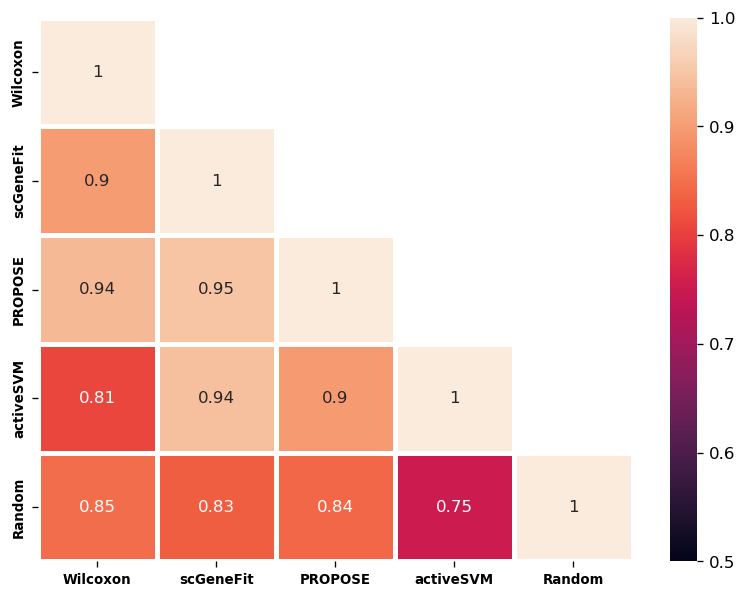

In [33]:
# Plot correlation between algorithm accuracy
corrAccuracy = np.corrcoef([np.diag(wlMatrix),np.diag(gfMatrix),np.diag(prMatrix),np.diag(svMatrix),np.diag(rMatrix)])

# Mask out upper triangle
mask = np.zeros_like(corrAccuracy)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

plt.figure(figsize=(8, 6), dpi=120)
sns.heatmap(corrAccuracy, vmin = .5, vmax = 1, linewidths = 2, annot = True, mask = mask)
plt.xticks(np.linspace(.5,4.5,5),["Wilcoxon","scGeneFit","PROPOSE","activeSVM","Random"], fontsize = 8, fontweight = 'bold')
plt.yticks(np.linspace(.5,4.5,5),["Wilcoxon","scGeneFit","PROPOSE","activeSVM","Random"], fontsize = 8, fontweight = 'bold');

#         plt.xticks(np.linspace(0.5,201.5,202), pd.unique(cluster), fontsize = 8)
#         plt.yticks(np.linspace(0.5,201.5,202), pd.unique(cluster), fontsize = 8)
#         plt.title("Classification Accuracy: %1.1f%%" %round(accuracy*100,2),fontsize=36)
#         plt.xlabel("Original Label", fontsize = 24)
#         plt.ylabel("Assigned Label", fontsize = 24)

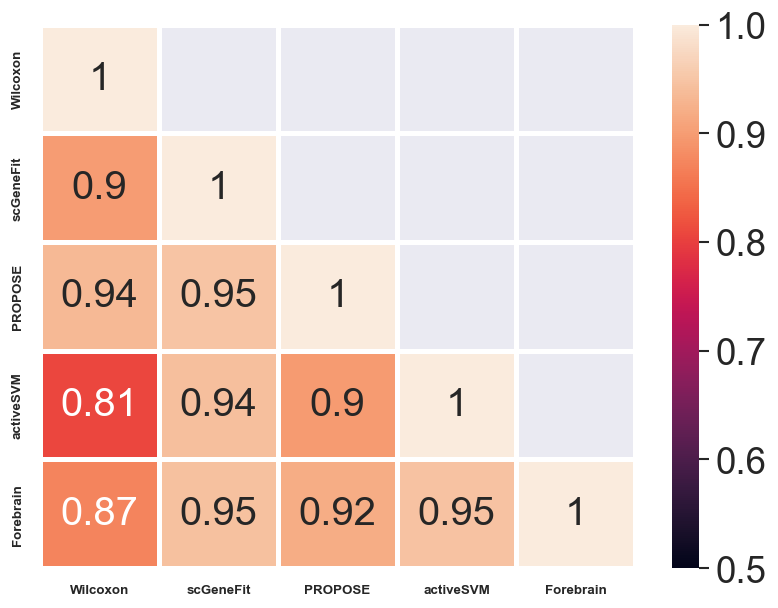

In [52]:
# Plot correlation between algorithm accuracy
corrAccuracy = np.corrcoef([np.diag(wlMatrix),np.diag(gfMatrix),np.diag(prMatrix),np.diag(svMatrix),np.diag(fbMatrix)])

# Mask out upper triangle
mask = np.zeros_like(corrAccuracy)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

plt.figure(figsize=(8, 6), dpi=120)
sns.heatmap(corrAccuracy, vmin = .5, vmax = 1, linewidths = 2, annot = True, mask = mask)
plt.xticks(np.linspace(.5,4.5,5),["Wilcoxon","scGeneFit","PROPOSE","activeSVM","Forebrain"], fontsize = 8, fontweight = 'bold')
plt.yticks(np.linspace(.5,4.5,5),["Wilcoxon","scGeneFit","PROPOSE","activeSVM","Forebrain"], fontsize = 8, fontweight = 'bold');

#         plt.xticks(np.linspace(0.5,201.5,202), pd.unique(cluster), fontsize = 8)
#         plt.yticks(np.linspace(0.5,201.5,202), pd.unique(cluster), fontsize = 8)
#         plt.title("Classification Accuracy: %1.1f%%" %round(accuracy*100,2),fontsize=36)
#         plt.xlabel("Original Label", fontsize = 24)
#         plt.ylabel("Assigned Label", fontsize = 24)